In [116]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GRU, Bidirectional, TimeDistributed, BatchNormalization, Embedding

from numpy import array
from keras.models import load_model
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

import os

import numpy as np
import pandas as pd
from tqdm import tqdm

from trackml.dataset import load_event, load_dataset
from trackml.score import score_event

import sys
sys.stdout = open('/dev/stdout', 'w')


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

In [2]:
def append_to_csv(batch, csv_file):
    props = dict(encoding='utf-8', index=False)
    if not os.path.exists(csv_file):
        batch.to_csv(csv_file, **props)
    else:
        batch.to_csv(csv_file, mode='a', header=False, **props)

def delete_file_if_exists(filename):
    if os.path.exists(filename):
        os.remove(filename)

In [3]:
def create_one_event_submission(event_id, hits, labels):
    sub_data = np.column_stack(([event_id]*len(hits), hits.hit_id.values, labels))
    submission = pd.DataFrame(data=sub_data, columns=["event_id", "hit_id", "track_id"]).astype(int)
    return submission

In [23]:
def my_loss(y_true, y_pred):
    print(y_pred.shape)
    print(y_true.shape)
    labels = [np.argmax(y_pred[i]) for i in range(y_pred.shape[1])]
    print(labels)
#     one_submission = create_one_event_submission(0, df_valid, labels)

    # Score for the event
#     score = score_event(df_valid, one_submission)
    score = 0.01
    return 1.0-score

In [5]:
from sklearn.preprocessing import StandardScaler
import hdbscan
from scipy import stats
from tqdm import tqdm

class Clusterer1(object):
    def __init__(self,rz_scales=[0.65, 0.965, 1.428]):                        
        self.rz_scales=rz_scales
    
    def _eliminate_outliers(self,labels,M):
        norms=np.zeros((len(labels)),np.float32)
        for i, cluster in tqdm(enumerate(labels),total=len(labels)):
            if cluster == 0:
                continue
            index = np.argwhere(self.clusters==cluster)
            x = M[index]
            norms[i] = self._test_quadric(x)
        threshold = np.percentile(norms,90)*5.3
        for i, cluster in tqdm(enumerate(labels),total=len(labels)):
            if norms[i] > threshold:
                self.clusters[self.clusters==cluster]=0            
    def _test_quadric(self,x):
        if len(x.shape)==3:
            x = np.reshape(x,(x.shape[0],3))
        Z = np.zeros((x.shape[0],10), np.float32)
        Z[:,0] = x[:,0]**2
        Z[:,1] = 2*x[:,0]*x[:,1]
        Z[:,2] = 2*x[:,0]*x[:,2]
        Z[:,3] = 2*x[:,0]
        Z[:,4] = x[:,1]**2
        Z[:,5] = 2*x[:,1]*x[:,2]
        Z[:,6] = 2*x[:,1]
        Z[:,7] = x[:,2]**2
        Z[:,8] = 2*x[:,2]
        Z[:,9] = 1
        v, s, t = np.linalg.svd(Z,full_matrices=False)        
        smallest_index = np.argmin(np.array(s))
        T = np.array(t)
        T = T[smallest_index,:]        
        norm = np.linalg.norm(np.dot(Z,T), ord=2)**2
        return norm

    def _preprocess(self, hits):
        
        x = hits.x.values
        y = hits.y.values
        z = hits.z.values

        r = np.sqrt(x**2 + y**2 + z**2)
        hits['x2'] = x/r
        hits['y2'] = y/r

        r = np.sqrt(x**2 + y**2)
        hits['z2'] = z/r

        ss = StandardScaler()
        X = ss.fit_transform(hits[['x2', 'y2', 'z2']].values)
        for i, rz_scale in enumerate(self.rz_scales):
            X[:,i] = X[:,i] * rz_scale

        
        return X
    
    def predict(self, hits):        
        volumes = np.unique(hits['volume_id'].values)
        X = self._preprocess(hits)
        self.clusters = np.zeros((len(X),1),np.int32)
        max_len = 1
        cl = hdbscan.HDBSCAN(min_samples=1,min_cluster_size=7,
                             metric='braycurtis',cluster_selection_method='leaf',algorithm='best', leaf_size=100)
        self.clusters = cl.fit_predict(X)+1
        labels = np.unique(self.clusters)
        n_labels = 0
        while n_labels < len(labels):
            n_labels = len(labels)
            self._eliminate_outliers(labels,X)
            max_len = np.max(self.clusters)
            self.clusters[self.clusters==0] = cl.fit_predict(X[self.clusters==0])+max_len
            labels = np.unique(self.clusters)
        return self.clusters

In [4]:
# hits = pd.read_csv('../cache/train_100_hits.csv')

In [5]:
# hits_1000 = hits[hits.event_id == 1000]

In [6]:
# hits_1000.shape

In [7]:
# hits_1000.particle_id.nunique()

In [8]:
# hits_1000_9 = hits_1000[hits_1000.nhits >= 9]

In [9]:
# hits_1000_9.shape

In [10]:
# hits_1000_9.particle_id.nunique()

In [22]:
hits = pd.read_csv('../cache/train_100_hits.csv')
hits = hits[hits.nhits >= 9]
hits = hits[(hits.event_id == 1004) | (hits.event_id == 1087)]

hits['new_pid'] = hits.particle_id.astype('str') + '_' + hits.event_id.astype('str')
# hits = hits_2_events
new_pid_list = list(set(hits.new_pid.values))
#
new_pid_count = list(range(len(new_pid_list)))
print(len(new_pid_count))
#
new_pid_dict = dict(zip(new_pid_list, new_pid_count))
#
hits['nid'] = hits['new_pid'].map(lambda x: new_pid_dict[x])
hits.sort_values(['nid', 'z'], inplace=True)
hits.to_csv('../cache/hits_2_nid_z_sorted_ge9.csv', index=False)
print(hits.shape)
print(hits.particle_id.nunique())


17643
(211724, 26)
16319


In [23]:
print(hits.new_pid.nunique())

17643


In [24]:
print(hits.nid.nunique())

17643


In [13]:
# new_pid_count = list(range(hits.new_pid.nunique()))
# new_pid_list = list(set(hits.new_pid.values))
# new_pid_dict = dict(zip(new_pid_list, new_pid_count))

In [14]:
# new_pid_count = list(range(100))
# new_pid_list = list(set(hits.new_pid.values))
# new_pid_list = np.random.choice(new_pid_list,100)
# new_pid_dict = dict(zip(new_pid_list, new_pid_count))

In [15]:
# hits = hits[hits.new_pid.isin(new_pid_list)]

In [16]:
hits['nid'] = hits['new_pid'].map(lambda x: new_pid_dict[x])
hits.sort_values(['nid', 'z'], inplace=True)

In [18]:
hits.to_csv('../cache/hits_100_nid_z_sorted_ge9.csv', index=False)

In [19]:
hits_2_events = hits[(hits.event_id == 1004) | (hits.event_id == 1087)]
hits_2_events.to_csv('../cache/hits_2_nid_z_sorted_ge9.csv', index=False)

In [20]:
hits_2_events.head(20)

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,vy,vz,px,py,pz,q,nhits,event_id,new_pid,nid
7813789,25659,17.8313,-26.2277,9.99095,8,2,118,927745440248496128,17.8315,-26.2275,...,0.00142,-1.33467,0.145227,-0.196880,0.087345,1.0,11.0,1087,927745440248496128_1087,12
7822127,34678,37.2692,-60.7604,24.28440,8,4,235,927745440248496128,37.2678,-60.7614,...,0.00142,-1.33467,0.145227,-0.196880,0.087345,1.0,11.0,1087,927745440248496128_1087,12
7829409,42662,55.5732,-102.5680,40.48650,8,6,382,927745440248496128,55.5714,-102.5690,...,0.00142,-1.33467,0.145227,-0.196880,0.087345,1.0,11.0,1087,927745440248496128_1087,12
7835725,49925,70.9304,-155.8290,59.85360,8,8,571,927745440248496128,70.9292,-155.8300,...,0.00142,-1.33467,0.145227,-0.196880,0.087345,1.0,11.0,1087,927745440248496128_1087,12
7868571,85673,79.9853,-243.5120,90.40000,13,2,453,927745440248496128,79.9978,-243.5090,...,0.00142,-1.33467,0.145227,-0.196880,0.087345,1.0,11.0,1087,927745440248496128_1087,12
7868558,85659,79.8836,-249.6810,92.20000,13,2,452,927745440248496128,79.8729,-249.6820,...,0.00142,-1.33467,0.145227,-0.196880,0.087345,1.0,11.0,1087,927745440248496128_1087,12
7875419,93547,63.5003,-353.3720,126.40000,13,4,632,927745440248496128,63.4958,-353.3720,...,0.00142,-1.33467,0.145227,-0.196880,0.087345,1.0,11.0,1087,927745440248496128_1087,12
7881777,101344,-14.5054,-499.3080,181.40000,13,6,956,927745440248496128,-14.5038,-499.3080,...,0.00142,-1.33467,0.145227,-0.196880,0.087345,1.0,11.0,1087,927745440248496128_1087,12
7881776,101343,-19.2380,-504.8300,183.80000,13,6,955,927745440248496128,-19.2298,-504.8320,...,0.00142,-1.33467,0.145227,-0.196880,0.087345,1.0,11.0,1087,927745440248496128_1087,12
7886792,108226,-205.8240,-624.4570,256.80000,13,8,1347,927745440248496128,-205.8350,-624.4520,...,0.00142,-1.33467,0.145227,-0.196880,0.087345,1.0,11.0,1087,927745440248496128_1087,12


In [21]:
hits_2_events.particle_id.nunique()

16319

In [29]:
# hits = hits[hits.new_pid.isin(new_pid_list)]
# hits['nid'] = hits['new_pid'].map(lambda x: new_pid_dict[x])


event_list = list(set(hits.event_id.values))
one_event = np.random.choice(event_list,1)
print(one_event)

hits_train = hits[hits.event_id != one_event[0]]
hits_test = hits[hits.event_id == one_event[0]]

[1034]


In [30]:
hits.head(20)

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,vy,vz,px,py,pz,q,nhits,event_id,new_pid,nid
3024406,115286,-114.81800,1016.4900,-601.80000,17,4,725,351284825384026112,-114.81500,1016.4900,...,-0.016244,-12.63500,0.181708,1.162610,-0.682243,-1.0,10.0,1031,351284825384026112_1031,0
3022102,110446,-46.83520,814.7320,-488.00000,17,2,692,351284825384026112,-46.82710,814.7320,...,-0.016244,-12.63500,0.181708,1.162610,-0.682243,-1.0,10.0,1031,351284825384026112_1031,0
3009764,94258,-11.59810,663.2530,-395.80000,13,8,689,351284825384026112,-11.60260,663.2540,...,-0.016244,-12.63500,0.181708,1.162610,-0.682243,-1.0,10.0,1031,351284825384026112_1031,0
3000380,81996,22.25660,360.5160,-221.00000,13,4,490,351284825384026112,22.25520,360.5160,...,-0.016244,-12.63500,0.181708,1.162610,-0.682243,-1.0,10.0,1031,351284825384026112_1031,0
2994180,74821,22.80610,260.1610,-163.40000,13,2,350,351284825384026112,22.79780,260.1630,...,-0.016244,-12.63500,0.181708,1.162610,-0.682243,-1.0,10.0,1031,351284825384026112_1031,0
2965213,42896,18.92340,171.4970,-112.46300,8,8,448,351284825384026112,18.92260,171.4970,...,-0.016244,-12.63500,0.181708,1.162610,-0.682243,-1.0,10.0,1031,351284825384026112_1031,0
2959464,36274,14.50140,116.1380,-80.39390,8,6,299,351284825384026112,14.50370,116.1380,...,-0.016244,-12.63500,0.181708,1.162610,-0.682243,-1.0,10.0,1031,351284825384026112_1031,0
2959449,36259,14.31060,114.1240,-79.22250,8,6,298,351284825384026112,14.31190,114.1240,...,-0.016244,-12.63500,0.181708,1.162610,-0.682243,-1.0,10.0,1031,351284825384026112_1031,0
2953760,29912,9.81963,72.0167,-54.76770,8,4,216,351284825384026112,9.82066,72.0167,...,-0.016244,-12.63500,0.181708,1.162610,-0.682243,-1.0,10.0,1031,351284825384026112_1031,0
2946054,21512,4.68117,31.7212,-31.23750,8,2,108,351284825384026112,4.68210,31.7211,...,-0.016244,-12.63500,0.181708,1.162610,-0.682243,-1.0,10.0,1031,351284825384026112_1031,0


In [31]:
hits_train.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,vy,vz,px,py,pz,q,nhits,event_id,new_pid,nid
3024406,115286,-114.8180,1016.490,-601.8,17,4,725,351284825384026112,-114.8150,1016.490,...,-0.016244,-12.635,0.181708,1.16261,-0.682243,-1.0,10.0,1031,351284825384026112_1031,0
3022102,110446,-46.8352,814.732,-488.0,17,2,692,351284825384026112,-46.8271,814.732,...,-0.016244,-12.635,0.181708,1.16261,-0.682243,-1.0,10.0,1031,351284825384026112_1031,0
3009764,94258,-11.5981,663.253,-395.8,13,8,689,351284825384026112,-11.6026,663.254,...,-0.016244,-12.635,0.181708,1.16261,-0.682243,-1.0,10.0,1031,351284825384026112_1031,0
3000380,81996,22.2566,360.516,-221.0,13,4,490,351284825384026112,22.2552,360.516,...,-0.016244,-12.635,0.181708,1.16261,-0.682243,-1.0,10.0,1031,351284825384026112_1031,0
2994180,74821,22.8061,260.161,-163.4,13,2,350,351284825384026112,22.7978,260.163,...,-0.016244,-12.635,0.181708,1.16261,-0.682243,-1.0,10.0,1031,351284825384026112_1031,0


In [32]:
X_train = hits_train[['x', 'y','z']].values
X_test = hits_test[['x', 'y', 'z']].values

y = hits_train['nid'].values

In [33]:
X_train.shape

(1196, 3)

In [34]:
X_test.shape

(23, 3)

In [35]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [36]:
filepath='../cache/checkpoint-{epoch:02d}.hdf5'
checkpoint = ModelCheckpoint(filepath, verbose=0, save_best_only=False)
callbacks_list = [checkpoint]

In [37]:
model = Sequential()
# model.add(BatchNormalization(input_shape=(1,2)))
model.add(Bidirectional(LSTM(100, return_sequences=True), input_shape=(1,3)))
# model.add(Bidirectional(LSTM(100, return_sequences=True)))
# model.add(Bidirectional(LSTM(2, return_sequences=True)))
model.add(Bidirectional(LSTM(100)))
# model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))

# model.add(Dense(100000, activation='relu'))

# model.add(Dropout(0.1))
model.add(Dense(100, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

In [38]:
%%time
model.fit(X_train.reshape(X_train.shape[0], 1, 3), y, batch_size=32, epochs=3000, shuffle=False, verbose=0, 
          callbacks=callbacks_list)

CPU times: user 45min 33s, sys: 2min 45s, total: 48min 19s
Wall time: 33min 18s


In [39]:
p = model.predict(X_test.reshape(X_test.shape[0],1,3))

In [40]:
p


array([[3.5299317e-17, 1.1957970e-31, 1.8576254e-25, ..., 1.9342209e-32,
        0.0000000e+00, 5.2022955e-24],
       [5.9805972e-17, 3.1903225e-31, 4.9929156e-25, ..., 8.0505976e-32,
        0.0000000e+00, 1.2540087e-23],
       [1.9447228e-12, 5.1224446e-18, 1.9589429e-13, ..., 1.2990869e-16,
        1.0657946e-24, 4.2109126e-16],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 2.6696397e-33,
        0.0000000e+00, 6.3860166e-30],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 2.0382572e-34,
        0.0000000e+00, 1.0537752e-31],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 7.1489153e-38,
        0.0000000e+00, 1.3837446e-33]], dtype=float32)

In [41]:
hits_test

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,vy,vz,px,py,pz,q,nhits,event_id,new_pid,nid
3207179,21897,-1.48676,31.5732,20.0519,8,2,124,333268159131811840,-1.48114,31.5729,...,0.006699,-4.79548,-0.005991,0.325940,0.256508,-1.0,12.0,1034,333268159131811840_1034,26
3207235,21955,-1.57258,32.7558,20.9826,8,2,125,333268159131811840,-1.57236,32.7559,...,0.006699,-4.79548,-0.005991,0.325940,0.256508,-1.0,12.0,1034,333268159131811840_1034,26
3213649,28993,-6.14156,71.6209,51.4871,8,4,249,333268159131811840,-6.14217,71.6207,...,0.006699,-4.79548,-0.005991,0.325940,0.256508,-1.0,12.0,1034,333268159131811840_1034,26
3220047,36128,-14.17280,114.5850,85.8295,8,6,456,333268159131811840,-14.17990,114.5830,...,0.006699,-4.79548,-0.005991,0.325940,0.256508,-1.0,12.0,1034,333268159131811840_1034,26
3220064,36145,-14.61110,116.4570,87.3451,8,6,457,333268159131811840,-14.60970,116.4570,...,0.006699,-4.79548,-0.005991,0.325940,0.256508,-1.0,12.0,1034,333268159131811840_1034,26
3225008,42012,-29.69190,169.3790,130.6700,8,8,685,333268159131811840,-29.69590,169.3780,...,0.006699,-4.79548,-0.005991,0.325940,0.256508,-1.0,12.0,1034,333268159131811840_1034,26
3251553,71392,-66.15700,253.8360,204.2000,13,2,512,333268159131811840,-66.18920,253.8330,...,0.006699,-4.79548,-0.005991,0.325940,0.256508,-1.0,12.0,1034,333268159131811840_1034,26
3257350,78277,-120.11700,335.4380,284.4000,13,4,774,333268159131811840,-120.09400,335.4440,...,0.006699,-4.79548,-0.005991,0.325940,0.256508,-1.0,12.0,1034,333268159131811840_1034,26
3262284,84728,-235.94100,443.0580,411.4000,13,6,1157,333268159131811840,-235.91600,443.0670,...,0.006699,-4.79548,-0.005991,0.325940,0.256508,-1.0,12.0,1034,333268159131811840_1034,26
3266238,90666,-401.39300,519.6880,560.6860,13,8,1618,333268159131811840,-401.39000,519.6900,...,0.006699,-4.79548,-0.005991,0.325940,0.256508,-1.0,12.0,1034,333268159131811840_1034,26


In [45]:
l = [np.argmax(p[i]) for i in range(len(p))]

In [46]:
l

[24,
 24,
 24,
 24,
 24,
 79,
 24,
 79,
 79,
 79,
 79,
 74,
 90,
 90,
 90,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3]

In [47]:
hits_test['l'] = l

In [51]:
sub=create_one_event_submission(0, hits_test, l)

In [52]:
score = score_event(hits_test, sub)

In [53]:
score

0.38280137363915484

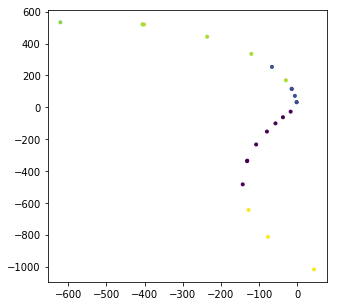

In [48]:
figure = plt.figure(figsize=(5,5))
plt.scatter(hits_test.x, hits_test.y, marker='.', c=hits_test.l)

In [21]:
t = np.array([0,1,2,3,4,5])
# Embedding(6, t)

In [22]:
t.shape

(6,)

In [23]:
model = Sequential()
model.add(Embedding(6, 1, input_length=1))
model.compile(optimizer='adam', loss='categorical_crossentropy')
output_array = model.predict(t)

In [24]:
output_array

array([[[-0.01161207]],

       [[-0.03734656]],

       [[-0.00973426]],

       [[-0.04064435]],

       [[ 0.00465965]],

       [[ 0.04648033]]], dtype=float32)

In [20]:
output_array[0][0][0]

0.047543276

In [27]:
output_array[1][0][0]

-0.037346564

In [69]:
model = Sequential()
# model.add(BatchNormalization(input_shape=(1,2)))
model.add(Bidirectional(LSTM(100, return_sequences=True), input_shape=(1,3)))
# model.add(Bidirectional(LSTM(100, return_sequences=True)))
# model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Bidirectional(LSTM(100)))
# model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))

# model.add(Dense(100000, activation='relu'))

# model.add(Dropout(0.1))
model.add(Dense(100, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

In [70]:
%%time
model.fit(X_train.reshape(X_train.shape[0], 1, 3), y, batch_size=32, epochs=3000, shuffle=False, verbose=0, 
          callbacks=callbacks_list)

CPU times: user 46min 18s, sys: 2min 52s, total: 49min 11s
Wall time: 34min 4s


In [71]:
p = model.predict(X_test.reshape(X_test.shape[0],1,3))

In [72]:
l = [np.argmax(p[i]) for i in range(len(p))]
hits_test['l'] = l
sub=create_one_event_submission(0, hits_test, l)
score = score_event(hits_test, sub)
print(score)

0.3492655565860047


In [73]:
# model.save('../cache/model-3-bilstm-100-particles.hdf5')
model.save('../cache/model-2-bilstm-100-particles.hdf5')

In [74]:
hits_test = hits_test.sample(frac=1).reset_index(drop=True)
hits_test = hits_test.sample(frac=1).reset_index(drop=True)
hits_test = hits_test.sample(frac=1).reset_index(drop=True)

In [75]:
hits_test.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,vz,px,py,pz,q,nhits,event_id,new_pid,nid,l
0,90666,-401.3930,519.688,560.686,13,8,1618,333268159131811840,-401.3900,519.690,...,-4.79548,-0.005991,0.325940,0.256508,-1.0,12.0,1034,333268159131811840_1034,26,79
1,88015,-127.3670,-645.072,-277.680,13,8,737,698061515655217152,-127.3570,-645.076,...,-1.55077,-0.291943,-0.443627,-0.219217,-1.0,11.0,1034,698061515655217152_1034,55,49
2,78277,-120.1170,335.438,284.400,13,4,774,333268159131811840,-120.0940,335.444,...,-4.79548,-0.005991,0.325940,0.256508,-1.0,12.0,1034,333268159131811840_1034,26,24
3,82301,-142.7700,-483.883,-212.600,13,6,640,698061515655217152,-142.7610,-483.887,...,-1.55077,-0.291943,-0.443627,-0.219217,-1.0,11.0,1034,698061515655217152_1034,55,90
4,108192,44.0244,-1017.840,-449.800,17,4,952,698061515655217152,43.9703,-1017.830,...,-1.55077,-0.291943,-0.443627,-0.219217,-1.0,11.0,1034,698061515655217152_1034,55,90


In [76]:
X_test = hits_test[['x', 'y', 'z']].values

In [77]:
p = model.predict(X_test.reshape(X_test.shape[0],1,3))
l = [np.argmax(p[i]) for i in range(len(p))]
hits_test['l'] = l
sub=create_one_event_submission(0, hits_test, l)
score = score_event(hits_test, sub)
print(score)

0.3492655565860048


In [78]:
hits = pd.read_csv('../cache/train_100_hits.csv')

In [80]:
hits.event_id.value_counts().sort_values()

1062     58499
1039     69130
1018     73301
1082     73727
1044     74548
1001     74650
1020     74872
1067     75310
1056     76670
1033     76735
1061     76805
1077     76857
1035     77006
1063     77102
1047     77182
1057     78712
1091     79737
1078     80580
1090     80619
1076     80822
1098     81021
1071     81368
1052     81437
1032     81681
1048     81768
1041     82210
1068     82379
1054     83362
1096     83828
1070     84150
         ...  
1028     96852
1053     97287
1024     97395
1051     97762
1011     97811
1099     97859
1016     98146
1084     98352
1006     98801
1079     98859
1088     99225
1058     99329
1025    100182
1086    100424
1080    100835
1097    101097
1092    101103
1000    101172
1031    102468
1015    102494
1019    102851
1026    103173
1093    103558
1040    104329
1017    104523
1002    105685
1014    106026
1023    108088
1087    116845
1004    118333
Name: event_id, Length: 100, dtype: int64

In [81]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,weight,vx,vy,vz,px,py,pz,q,nhits,event_id
0,2,-55.3361,0.635342,-1502.5,7,2,1,22525763437723648,-55.3385,0.630805,...,0.000010,-0.015802,0.006381,1.16279,-0.569670,-0.011187,-15.49600,1.0,10.0,1000
1,4,-96.1091,-8.241030,-1502.5,7,2,1,297237712845406208,-96.1229,-8.230360,...,0.000008,-0.000486,-0.015051,5.75865,-0.240629,0.012071,-3.70766,-1.0,11.0,1000
2,5,-62.6736,-9.371200,-1502.5,7,2,1,418835796137607168,-62.6594,-9.375040,...,0.000009,0.018365,-0.016865,4.19268,-0.268943,-0.058487,-6.58619,1.0,10.0,1000
3,6,-57.0687,-8.177770,-1502.5,7,2,1,108087696726949888,-57.0856,-8.189710,...,0.000008,0.010383,-0.012398,3.92894,-0.392669,-0.075470,-10.47140,1.0,11.0,1000
4,7,-73.8723,-2.578900,-1502.5,7,2,1,968286151951515648,-73.8608,-2.575860,...,0.000007,-0.004178,0.004751,-5.12884,-0.453130,0.008006,-9.13374,-1.0,13.0,1000


In [82]:
# hits = pd.read_csv('../cache/train_100_hits.csv')
hits['new_pid'] = hits.particle_id.astype('str') + '_' + hits.event_id.astype('str') 
hits = hits[hits.nhits >= 9]

In [93]:
hits1 = hits.groupby(['event_id', 'particle_id']).size()

In [94]:
hits1

event_id  particle_id       
1000      4503737066323968      11
          4503874505277440      12
          4504011944230912      12
          4504080663707648      14
          4504355541614592      17
          4504424261091328      12
          4504561700044800      10
          4504630419521536      12
          4504699138998272      10
          4504767858475008      12
          4504905297428480      14
          4505317614288896      11
          4505386333765632      11
          4505455053242368       9
          4505523772719104      12
          4505661211672576      10
          4505729931149312      11
          4505798650626048      10
          4505867370102784      13
          4505936089579520      14
          4506004809056256      10
          4506073528532992      12
          4506348406439936      11
          4506417142702082      12
          4506485845393408      13
          4506554564870144      13
          4506623284346880      13
          4506692003823616

In [109]:
hits1 = hits.groupby(['event_id', 'particle_id']).agg({'event_id': ['count']})

SyntaxError: invalid syntax (<ipython-input-109-748e29fdd6fe>, line 1)

In [108]:
hits1

event_id
                               count
event_id particle_id                
1000     4503737066323968         11
         4503874505277440         12
         4504011944230912         12
         4504080663707648         14
         4504355541614592         17
         4504424261091328         12
         4504561700044800         10
         4504630419521536         12
         4504699138998272         10
         4504767858475008         12
         4504905297428480         14
         4505317614288896         11
         4505386333765632         11
         4505455053242368          9
         4505523772719104         12
         4505661211672576         10
         4505729931149312         11
         4505798650626048         10
         4505867370102784         13
         4505936089579520         14
         4506004809056256         10
         4506073528532992         12
         4506348406439936         11
         4506417142702082         12
         4506485845393408         13
         4506554564870144         13
         4506623284346880         13
         4506692003823616         13
         4506829442777088         11
         4506898162253824         13
...                              ...
1099     927748257747042304       13
         927748326466519040       12
         927748395185995776       13
         927748463905472512       16
         927748532624949248       12
         927749563417100288       12
         927749632136577024       10
         927750250611867648       12
         927750800367681536       10
         927750869087158272       14
         927751075245588480       12
         927751556281925632       12
         927751762440355840       14
         927751831159832576       13
         927752312196169728       12
         927752380915646464       10
         927755129694715904       15
         932245191585169408       13
         932245535182553088       11
         932245603902029824       12
         932246016218890240       11
         932246084938366976       13
         932246565974704128       11
         932246634694180864       10
         932246703413657600       11
         932246772133134336        9
         932246840852611072       13
         932246909572087808       11
         932249383473250304       11
         932249452192727040        9

[676423 rows x 1 columns]

In [117]:
event_list = list(set(hits.event_id.values))

In [119]:
max1 = 0
max2 = 0
evt_id1 = 0
evt_id2 = 0

In [120]:
for evt_id in tqdm(event_list):
    df = hits[hits.event_id == evt_id]
    num_p = df.particle_id.nunique()
    if num_p > max1:
        max2 = max1
        evt_id2 = evt_id1
        
        max1 = num_p
        evt_id1 = evt_id


100%|██████████| 100/100 [00:01<00:00, 62.66it/s]

In [121]:
print(max1, max2)
print(evt_id1, evt_id2)

8884 8759
1004 1087


In [122]:
path_to_train = "../data/train"
train_sample_scores = []

max1 = 0
max2 = 0
evt_id1 = 0
evt_id2 = 0

for event_id, hits, cells, particles, truth in tqdm(load_dataset(path_to_train)):

    num_p = truth.particle_id.nunique()
    if num_p > max1:
        max2 = max1
        evt_id2 = evt_id1
        
        max1 = num_p
        evt_id1 = event_id


0it [00:00, ?it/s]
1it [00:00,  1.36it/s]
2it [00:01,  1.27it/s]
3it [00:02,  1.36it/s]
4it [00:02,  1.45it/s]
5it [00:03,  1.46it/s]
6it [00:04,  1.47it/s]
7it [00:04,  1.48it/s]
8it [00:05,  1.50it/s]
9it [00:05,  1.52it/s]
10it [00:06,  1.53it/s]
11it [00:07,  1.55it/s]
12it [00:07,  1.55it/s]
13it [00:08,  1.56it/s]
8850it [1:28:56,  1.66it/s]


In [123]:
print(max1, max2)
print(evt_id1, evt_id2)

13989 13189
6488 6216


In [4]:
hits = pd.read_csv('../cache/train_100_hits.csv')
hits['new_pid'] = hits.particle_id.astype('str') + '_' + hits.event_id.astype('str') 
# hits = hits[hits.nhits >= 9]

In [5]:
hits = hits[hits.nhits >= 9]

In [6]:
hits_2_events = hits[(hits.event_id == 1004) | (hits.event_id == 1087)]

In [7]:
hits_2_events.shape

(211724, 25)

In [8]:
hits_2_events.to_csv('../cache/hits_2_events_ge9.csv')

In [9]:
hits = hits_2_events
new_pid_list = list(set(hits.new_pid.values))

new_pid_count = list(range(len(new_pid_list)))
new_pid_dict = dict(zip(new_pid_list, new_pid_count))
    
    
hits['nid'] = hits['new_pid'].map(lambda x: new_pid_dict[x])
hits.sort_values(['nid', 'z'], inplace=True)


In [10]:
hits.tail()

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,vy,vz,px,py,pz,q,nhits,event_id,new_pid,nid
468322,113693,159.770,-211.619,1498.5,14,4,58,351285718737223680,159.595,-211.333,...,0.007675,-2.82624,0.400151,-0.655639,4.37119,-1.0,13.0,1004,351285718737223680_1004,17642
469744,115305,195.809,-250.033,1795.5,14,6,62,351285718737223680,195.729,-249.979,...,0.007675,-2.82624,0.400151,-0.655639,4.37119,-1.0,13.0,1004,351285718737223680_1004,17642
471102,116870,239.534,-294.800,2145.5,14,8,62,351285718737223680,239.431,-294.668,...,0.007675,-2.82624,0.400151,-0.655639,4.37119,-1.0,13.0,1004,351285718737223680_1004,17642
472398,118361,291.120,-346.833,2554.5,14,10,63,351285718737223680,291.371,-347.115,...,0.007675,-2.82624,0.400151,-0.655639,4.37119,-1.0,13.0,1004,351285718737223680_1004,17642
473633,119788,342.551,-399.042,2954.5,14,12,63,351285718737223680,342.670,-399.174,...,0.007675,-2.82624,0.400151,-0.655639,4.37119,-1.0,13.0,1004,351285718737223680_1004,17642


In [11]:
len(new_pid_list)

17643

In [12]:
model = Sequential()
# model.add(BatchNormalization(input_shape=(1,2)))
model.add(Bidirectional(LSTM(100, return_sequences=True), input_shape=(1,3)))
# model.add(Bidirectional(LSTM(100, return_sequences=True)))
# model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Bidirectional(LSTM(100)))
# model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))

# model.add(Dense(100000, activation='relu'))

# model.add(Dropout(0.1))
model.add(Dense(100, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

In [13]:
for n in range(177):
    w_start = n*100
    w_end = (n+1)*100
    if w_end > 17643:
        w_end = 17643
    hits1 = hits[(hits.nid >= w_start) & (hits.nid < w_end)]
   
    str1='../cache/checkpoint/checkpoint-{}'.format(n)
    str2 = '{epoch:02d}.hdf5'
    filepath = str1 + '-' + str2
    checkpoint = ModelCheckpoint(filepath, verbose=0, save_best_only=False)
    callbacks_list = [checkpoint]

    X_train = hits1[['x', 'y', 'z']].values
    
    y = hits1['nid'].values
    print(X_train.shape)
#     model.fit(X_train.reshape(X_train.shape[0], 1, 3), y, batch_size=32, epochs=3000, shuffle=False, verbose=0, 
#           callbacks=callbacks_list)

(1193, 3)
(1192, 3)
(1194, 3)
(1203, 3)
(1186, 3)
(1215, 3)
(1187, 3)
(1178, 3)
(1200, 3)
(1204, 3)
(1201, 3)
(1199, 3)
(1217, 3)
(1221, 3)
(1193, 3)
(1181, 3)
(1206, 3)
(1172, 3)
(1173, 3)
(1181, 3)
(1196, 3)
(1210, 3)
(1210, 3)
(1189, 3)
(1224, 3)
(1219, 3)
(1211, 3)
(1199, 3)
(1174, 3)
(1184, 3)
(1215, 3)
(1183, 3)
(1171, 3)
(1197, 3)
(1196, 3)
(1168, 3)
(1191, 3)
(1206, 3)
(1192, 3)
(1160, 3)
(1228, 3)
(1184, 3)
(1173, 3)
(1222, 3)
(1175, 3)
(1178, 3)
(1209, 3)
(1202, 3)
(1200, 3)
(1222, 3)
(1179, 3)
(1188, 3)
(1220, 3)
(1199, 3)
(1188, 3)
(1206, 3)
(1228, 3)
(1157, 3)
(1248, 3)
(1211, 3)
(1227, 3)
(1204, 3)
(1221, 3)
(1187, 3)
(1206, 3)
(1175, 3)
(1193, 3)
(1209, 3)
(1217, 3)
(1211, 3)
(1218, 3)
(1235, 3)
(1199, 3)
(1226, 3)
(1209, 3)
(1212, 3)
(1190, 3)
(1223, 3)
(1188, 3)
(1166, 3)
(1197, 3)
(1194, 3)
(1174, 3)
(1216, 3)
(1191, 3)
(1207, 3)
(1191, 3)
(1183, 3)
(1199, 3)
(1211, 3)
(1192, 3)
(1211, 3)
(1189, 3)
(1197, 3)
(1201, 3)
(1223, 3)
(1170, 3)
(1203, 3)
(1211, 3)
(1214, 3)


In [24]:
path_to_train = "../data/train"
event_prefix = "event000006488"
hits, cells, particles, truth = load_event(os.path.join(path_to_train, event_prefix))

truth1 = pd.merge(truth, particles, how='left', on='particle_id')
hits1 = pd.merge(hits, truth1, how='left', on='hit_id')

hits2 = hits1.dropna()
truth2 = truth1.dropna()

hits3 = hits2[hits2.nhits >= 9]
truth3 = truth2[truth2.nhits >= 9]

hits3['event_id'] = 6488
hits3['new_pid'] = hits3.particle_id.astype('str') + '_' + hits3.event_id.astype('str') 
hits3.to_csv('../cache/hits_6488.csv', index=False)
truth3.to_csv('../cache/truth_6488.csv', index=False)

In [25]:
hits = pd.read_csv('../cache/hits_6488.csv')

In [26]:
hits.shape

(121814, 25)

In [27]:
hits.particle_id.nunique()

10149

In [28]:
new_pid_list = list(set(hits.new_pid.values))

new_pid_count = list(range(len(new_pid_list)))
new_pid_dict = dict(zip(new_pid_list, new_pid_count))
    
    
hits['nid'] = hits['new_pid'].map(lambda x: new_pid_dict[x])
hits.sort_values(['nid', 'z'], inplace=True)

In [31]:
hits.tail()

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,vy,vz,px,py,pz,q,nhits,event_id,new_pid,nid
46974,55458,127.6350,116.0170,-86.3421,8,8,439,139615368019705856,127.6380,116.0150,...,0.006823,-7.33897,0.717325,0.581459,-0.425044,-1.0,11.0,6488,139615368019705856_6488,10148
41139,47834,88.4567,77.4909,-61.2592,8,6,345,139615368019705856,88.4550,77.4922,...,0.006823,-7.33897,0.717325,0.581459,-0.425044,-1.0,11.0,6488,139615368019705856_6488,10148
41118,47809,86.9582,76.0742,-60.3251,8,6,344,139615368019705856,86.9563,76.0761,...,0.006823,-7.33897,0.717325,0.581459,-0.425044,-1.0,11.0,6488,139615368019705856_6488,10148
33446,38259,54.9237,46.6868,-40.4045,8,4,212,139615368019705856,54.9260,46.6847,...,0.006823,-7.33897,0.717325,0.581459,-0.425044,-1.0,11.0,6488,139615368019705856_6488,10148
23994,26672,24.6060,20.3901,-22.0351,8,2,106,139615368019705856,24.6060,20.3902,...,0.006823,-7.33897,0.717325,0.581459,-0.425044,-1.0,11.0,6488,139615368019705856_6488,10148


In [35]:
model = Sequential()
# model.add(BatchNormalization(input_shape=(1,2)))
model.add(Bidirectional(LSTM(100, return_sequences=True), input_shape=(1,3)))
# model.add(Bidirectional(LSTM(100, return_sequences=True)))
# model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Bidirectional(LSTM(100)))
# model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))

# model.add(Dense(100000, activation='relu'))

# model.add(Dropout(0.1))
model.add(Dense(10149, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

In [36]:
for n in tqdm(range(102)):
#     if n == 0:
#         continue
    w_start = n*100
    w_end = (n+1)*100
    if w_end > 10149:
        w_end = 10149
    hits1 = hits[(hits.nid >= w_start) & (hits.nid < w_end)]
   
    str1='../cache/checkpoint/checkpoint-6488-{}'.format(n)
    str2 = '{epoch:02d}.hdf5'
    filepath = str1 + '-' + str2
    checkpoint = ModelCheckpoint(filepath, verbose=0, save_best_only=False)
    callbacks_list = [checkpoint]

    print(hits1.head())
    X_train = hits1[['x', 'y', 'z']].values
    
    y = hits1['nid'].values
    print(y)
    print(len(y))
    print(X_train.shape)
    
    model.fit(X_train.reshape(X_train.shape[0], 1, 3), y, batch_size=32, epochs=3000, shuffle=False, verbose=0, 
          callbacks=callbacks_list)


  0%|          | 0/102 [00:00<?, ?it/s]

       hit_id         x         y        z  volume_id  layer_id  module_id  \
29431   33231   8.06748  -31.0094  235.255          8         2        165   
51857   61684  19.70140  -78.9564  597.500          9         2         31   
55531   65744  22.69030  -92.2628  697.500          9         4         31   
59267   69785  26.22300 -108.3270  818.000          9         6         32   
62791   73536  30.21400 -127.0420  958.000          9         8         32   

              particle_id        tx        ty ...         vy        vz  \
29431  270220444408217600   8.07083  -31.0083 ...   0.002727  0.248166   
51857  270220444408217600  19.67640  -78.9580 ...   0.002727  0.248166   
55531  270220444408217600  22.70700  -92.2612 ...   0.002727  0.248166   
59267  270220444408217600  26.22730 -108.3320 ...   0.002727  0.248166   
62791  270220444408217600  30.19250 -127.0550 ...   0.002727  0.248166   

             px       py       pz    q  nhits  event_id  \
29431  0.367941 -1.37672  1


  1%|          | 1/102 [29:16<49:16:26, 1756.30s/it]

       hit_id        x        y        z  volume_id  layer_id  module_id  \
29715   33565 -29.6987  11.9326  233.186          8         2        175   
29755   33617 -31.2809  12.4858  245.347          8         2        176   
54235   64326 -78.0655  24.8943  598.000          9         2        101   
54322   64430 -78.5938  25.0135  602.000          9         2        104   
57996   68421 -92.0232  27.2606  702.000          9         4        104   

              particle_id       tx       ty ...         vy        vz  \
29715  270235287815192576 -29.6988  11.9326 ...   0.002727  0.248166   
29755  270235287815192576 -31.2809  12.4854 ...   0.002727  0.248166   
54235  270235287815192576 -78.0597  24.8971 ...   0.002727  0.248166   
54322  270235287815192576 -78.5964  24.9989 ...   0.002727  0.248166   
57996  270235287815192576 -92.0267  27.2747 ...   0.002727  0.248166   

             px        py       pz    q  nhits  event_id  \
29715 -0.186652  0.084932  1.49319 -1.0   12.0    

  2%|▏         | 2/102 [58:42<48:55:47, 1761.48s/it]

       hit_id         x         y        z  volume_id  layer_id  module_id  \
29758   33620  -31.4333   9.78446  244.209          8         2        176   
54361   64474  -80.0311  22.01620  602.000          9         2        104   
58019   68444  -93.7110  24.83770  702.000          9         4        104   
61730   72388 -109.5940  27.80510  818.000          9         6        105   
64905   75790 -128.8950  30.90640  958.000          9         8        105   

             particle_id        tx        ty ...         vy       vz  \
29758  36032301712277504  -31.4333   9.78414 ...  -0.004063  9.33087   
54361  36032301712277504  -80.0272  22.00900 ...  -0.004063  9.33087   
58019  36032301712277504  -93.7159  24.83700 ...  -0.004063  9.33087   
61730  36032301712277504 -109.6000  27.78840 ...  -0.004063  9.33087   
64905  36032301712277504 -128.8960  30.89910 ...  -0.004063  9.33087   

             px        py       pz    q  nhits  event_id  \
29758 -0.433307  0.145548  3.26061 -1.

  3%|▎         | 3/102 [1:28:05<48:26:54, 1761.76s/it]

        hit_id        x        y       z  volume_id  layer_id  module_id  \
113980  140484  634.296 -512.770 -889.20         17         2        168   
99002   120198  473.287 -457.991 -707.92         13         8        345   
94316   112960  325.808 -376.216 -531.20         13         6        419   
88520   104695  217.699 -290.534 -387.40         13         4        356   
81918    95836  145.060 -216.185 -277.20         13         2        294   

                particle_id       tx       ty ...         vy       vz  \
113980  1094385979445215232  634.321 -512.746 ...   0.003977 -1.24378   
99002   1094385979445215232  473.302 -457.980 ...   0.003977 -1.24378   
94316   1094385979445215232  325.827 -376.204 ...   0.003977 -1.24378   
88520   1094385979445215232  217.718 -290.524 ...   0.003977 -1.24378   
81918   1094385979445215232  145.050 -216.189 ...   0.003977 -1.24378   

              px       py        pz    q  nhits  event_id  \
113980  0.253769 -0.51394 -0.604658 -1.0   

  4%|▍         | 4/102 [1:57:56<48:09:27, 1769.06s/it]

       hit_id        x         y        z  volume_id  layer_id  module_id  \
28789   32432 -2.22599  -31.3638  209.258          8         2        148   
29425   33221 -2.26436  -31.8575  212.440          8         2        164   
37854   43671 -5.85497  -71.3552  467.200          8         4        424   
51678   61488 -8.03568  -91.5880  598.000          9         2         25   
55396   65594 -9.86556 -107.0960  698.000          9         4         26   

              particle_id       tx        ty ...         vy       vz       px  \
28789  761109299098288128 -2.22697  -31.3637 ...  -0.003618  6.64178 -0.06816   
29425  761109299098288128 -2.26670  -31.8574 ...  -0.003618  6.64178 -0.06816   
37854  761109299098288128 -5.85206  -71.3551 ...  -0.003618  6.64178 -0.06816   
51678  761109299098288128 -8.04472  -91.5885 ...  -0.003618  6.64178 -0.06816   
55396  761109299098288128 -9.85958 -107.0950 ...  -0.003618  6.64178 -0.06816   

            py      pz    q  nhits  event_id      

  5%|▍         | 5/102 [2:30:04<48:31:34, 1800.98s/it]

       hit_id         x         y         z  volume_id  layer_id  module_id  \
25300   28184  -25.2129  -18.9674   60.0795          8         2        114   
36216   41554  -55.5955  -45.3963  143.4340          8         4        292   
43684   50972  -86.0751  -76.9241  233.8750          8         6        526   
43689   50980  -87.3266  -78.3419  237.7650          8         6        527   
49969   59312 -121.1190 -121.1320  350.3740          8         8        868   

              particle_id        tx        ty ...         vy       vz  \
25300  157639387255930880  -25.2128  -18.9676 ...  -0.001944 -5.20016   
36216  157639387255930880  -55.5950  -45.3968 ...  -0.001944 -5.20016   
43684  157639387255930880  -86.0712  -76.9278 ...  -0.001944 -5.20016   
43689  157639387255930880  -87.3244  -78.3435 ...  -0.001944 -5.20016   
49969  157639387255930880 -121.1290 -121.1250 ...  -0.001944 -5.20016   

             px        py       pz    q  nhits  event_id  \
25300 -0.253949 -0.179677 

  6%|▌         | 6/102 [3:27:02<55:12:33, 2070.35s/it]

        hit_id         x         y         z  volume_id  layer_id  module_id  \
28750    32379  -17.9453  -26.2517   142.602          8         2        147   
37238    42867  -40.6679  -58.4184   322.094          8         4        357   
51424    61209  -77.0748 -107.7820   602.000          9         2         18   
55115    65288  -90.4743 -125.1310   702.000          9         4         18   
102823  126635 -161.8190 -212.7620  1215.500         14         2         24   

               particle_id        tx        ty ...         vy       vz  \
28750   202663563779637248  -17.9482  -26.2503 ...  -0.001382 -2.21932   
37238   202663563779637248  -40.6660  -58.4196 ...  -0.001382 -2.21932   
51424   202663563779637248  -77.0906 -107.7760 ...  -0.001382 -2.21932   
55115   202663563779637248  -90.4675 -125.1380 ...  -0.001382 -2.21932   
102823  202663563779637248 -161.4960 -212.3540 ...  -0.001382 -2.21932   

              px       py       pz    q  nhits  event_id  \
28750  -0.8343

  7%|▋         | 7/102 [4:23:48<59:40:15, 2261.22s/it]

        hit_id        x         y      z  volume_id  layer_id  module_id  \
117199  147428  979.874 -297.3670 -612.6         17         4        677   
114517  141640  798.943 -183.5400 -488.0         17         2        656   
99629   121267  649.867 -113.5960 -390.4         13         8        661   
94926   113886  494.832  -60.2065 -292.0         13         6        584   
89348   105800  359.411  -27.5424 -209.0         13         4        476   

              particle_id       tx        ty ...         vy      vz        px  \
117199  76569714880413696  979.886 -297.3420 ...  -0.004107  7.5007  0.945316   
114517  76569714880413696  798.954 -183.5140 ...  -0.004107  7.5007  0.945316   
99629   76569714880413696  649.870 -113.5870 ...  -0.004107  7.5007  0.945316   
94926   76569714880413696  494.832  -60.2084 ...  -0.004107  7.5007  0.945316   
89348   76569714880413696  359.412  -27.5368 ...  -0.004107  7.5007  0.945316   

              py        pz    q  nhits  event_id        

  8%|▊         | 8/102 [5:24:18<63:30:37, 2432.32s/it]

        hit_id         x        y      z  volume_id  layer_id  module_id  \
114209  140970 -251.5100 -775.876 -715.6         17         2        385   
99159   120458 -174.5860 -635.980 -576.6         13         8        430   
94547   113303 -110.8760 -490.703 -440.2         13         6        485   
88813   105085  -64.0307 -352.123 -315.6         13         4        405   
82328    96346  -40.5041 -262.614 -236.0         13         2        329   

               particle_id        tx       ty ...         vy       vz  \
114209  139616536250810368 -251.4950 -775.883 ...   0.006823 -7.33897   
99159   139616536250810368 -174.5970 -635.976 ...   0.006823 -7.33897   
94547   139616536250810368 -110.8900 -490.697 ...   0.006823 -7.33897   
88813   139616536250810368  -64.0160 -352.128 ...   0.006823 -7.33897   
82328   139616536250810368  -40.5006 -262.615 ...   0.006823 -7.33897   

              px      py        pz    q  nhits  event_id  \
114209 -0.076199 -1.0291 -0.889167  1.0   13

  9%|▉         | 9/102 [6:23:19<66:01:00, 2555.49s/it]

      hit_id        x        y       z  volume_id  layer_id  module_id  \
274      298 -32.8395 -46.3643 -1502.0          7         2         17   
233      256 -32.6999 -46.2549 -1498.0          7         2         14   
2050    2233 -27.9794 -40.4430 -1302.0          7         4         17   
1976    2155 -27.8649 -40.3629 -1298.0          7         4         14   
4207    4568 -23.2522 -34.4513 -1102.0          7         6         17   

             particle_id       tx       ty ...         vy       vz        px  \
274   792635114965172224 -32.8223 -46.3726 ...   0.009702  0.36014 -0.110967   
233   792635114965172224 -32.7241 -46.2556 ...   0.009702  0.36014 -0.110967   
2050  792635114965172224 -27.9770 -40.4656 ...   0.009702  0.36014 -0.110967   
1976  792635114965172224 -27.8815 -40.3465 ...   0.009702  0.36014 -0.110967   
4207  792635114965172224 -23.2472 -34.4615 ...   0.009702  0.36014 -0.110967   

            py       pz    q  nhits  event_id                  new_pid  ni

 10%|▉         | 10/102 [7:24:01<68:05:02, 2664.15s/it]

       hit_id         x        y         z  volume_id  layer_id  module_id  \
27392   30660  -28.1271  14.0535   43.7236          8         2        127   
36066   41362  -65.9412  27.9866   98.2136          8         4        286   
36109   41411  -67.9533  28.5849  101.0500          8         4        287   
43600   50859 -109.9270  37.9956  159.2790          8         6        518   
49906   59230 -166.3390  41.6932  236.0610          8         8        855   

              particle_id        tx       ty  ...         vy       vz  \
27392  180149757530865664  -28.1247  14.0585  ...   0.022513  1.21809   
36066  180149757530865664  -65.9417  27.9852  ...   0.022513  1.21809   
36109  180149757530865664  -67.9532  28.5851  ...   0.022513  1.21809   
43600  180149757530865664 -109.9270  37.9958  ...   0.022513  1.21809   
49906  180149757530865664 -166.3370  41.7071  ...   0.022513  1.21809   

             px      py        pz    q  nhits  event_id  \
27392 -0.181073  0.1009  0.279683

 11%|█         | 11/102 [8:24:39<69:34:54, 2752.69s/it]

      hit_id        x         y       z  volume_id  layer_id  module_id  \
844      919  81.7729  14.03410 -1502.5          7         2         55   
911      991  81.5508  13.99950 -1498.0          7         2         58   
2761    3009  70.9556  11.67810 -1302.5          7         4         55   
2816    3069  70.7290  11.60710 -1298.0          7         4         58   
5099    5533  60.1266   9.47168 -1102.5          7         6         55   

             particle_id       tx        ty  ...         vy       vz  \
844   783630527050547200  81.7901  14.03150  ...  -0.004806 -2.06463   
911   783630527050547200  81.5459  13.97810  ...  -0.004806 -2.06463   
2761  783630527050547200  70.9595  11.67250  ...  -0.004806 -2.06463   
2816  783630527050547200  70.7159  11.62090  ...  -0.004806 -2.06463   
5099  783630527050547200  60.1197   9.46977  ...  -0.004806 -2.06463   

            px        py       pz    q  nhits  event_id  \
844   0.510195  0.061886 -9.28873 -1.0   15.0      6488  

 12%|█▏        | 12/102 [9:24:55<70:36:59, 2824.66s/it]

       hit_id         x         y        z  volume_id  layer_id  module_id  \
45705   53806 -131.8490  111.5420 -279.875          8         8        226   
46097   54333 -131.5260  111.1190 -279.726          8         8        304   
39306   45580  -98.8845   60.2849 -262.823          8         6        204   
82325   96341  -79.3828 -246.8310 -168.200         13         2        329   
82317   96330  -81.7381 -252.6520 -165.800         13         2        328   

             particle_id        tx        ty  ...        vy      vz        px  \
45705  45038057874792450 -131.8480  111.5430  ...   113.162 -280.44  0.136492   
46097  45038057874792450 -131.5250  111.1200  ...   113.162 -280.44  0.136492   
39306  45038057874792450  -98.8829   60.2887  ...   113.162 -280.44  0.136492   
82325  45038057874792450  -79.3978 -246.8250  ...   113.162 -280.44  0.136492   
82317  45038057874792450  -81.7364 -252.6530  ...   113.162 -280.44  0.136492   

             py        pz    q  nhits  event

 13%|█▎        | 13/102 [10:25:12<71:20:19, 2885.61s/it]

        hit_id         x        y      z  volume_id  layer_id  module_id  \
116998  146848  261.4360 -986.010 -829.4         17         4        349   
114350  141280   78.4303 -819.968 -655.8         17         2        512   
99375   120820  -19.8843 -655.495 -519.2         13         8        536   
94552   113313  -68.3656 -498.890 -403.0         13         6        486   
88806   105077  -81.6612 -352.564 -299.7         13         4        404   

               particle_id        tx       ty  ...        vy       vz  \
116998  445873749137293312  261.4280 -986.011  ...  -66.0371 -95.5617   
114350  445873749137293312   78.4313 -819.968  ...  -66.0371 -95.5617   
99375   445873749137293312  -19.8930 -655.493  ...  -66.0371 -95.5617   
94552   445873749137293312  -68.3885 -498.883  ...  -66.0371 -95.5617   
88806   445873749137293312  -81.6717 -352.559  ...  -66.0371 -95.5617   

              px        py       pz    q  nhits  event_id  \
116998 -0.174782 -0.421384 -0.31932 -1.0   

 14%|█▎        | 14/102 [11:25:49<71:50:57, 2939.28s/it]

       hit_id        x         y       z  volume_id  layer_id  module_id  \
71718   83212 -461.132 -172.9100 -2951.5         12         2         11   
73061   84774 -401.993 -143.2180 -2551.5         12         4         11   
74403   86312 -341.043 -113.9600 -2148.5         12         6          8   
75823   87962 -287.445  -90.0638 -1798.5         12         8          8   
77271   89675 -241.206  -70.8761 -1498.5         12        10          8   

              particle_id       tx        ty  ...        vy       vz  \
71718  797163041287307264 -461.503 -173.0510  ...  -1.40521 -29.1961   
73061  797163041287307264 -402.053 -143.2570  ...  -1.40521 -29.1961   
74403  797163041287307264 -341.157 -113.9940  ...  -1.40521 -29.1961   
75823  797163041287307264 -287.449  -90.0377  ...  -1.40521 -29.1961   
77271  797163041287307264 -240.763  -70.7793  ...  -1.40521 -29.1961   

             px        py      pz    q  nhits  event_id  \
71718 -0.808828 -0.155585 -4.8774 -1.0   11.0      

 15%|█▍        | 15/102 [12:25:56<72:06:27, 2983.77s/it]

        hit_id        x        y      z  volume_id  layer_id  module_id  \
117036  146956  206.677  997.677 -872.6         17         4        414   
114277  141116  249.662  776.741 -683.2         17         2        445   
99465   120973  250.369  606.888 -542.0         13         8        581   
94681   113504  226.043  449.207 -410.6         13         6        521   
89004   105341  182.246  306.984 -288.4         13         4        430   

               particle_id       tx       ty  ...         vy       vz  \
117036  585471456251478016  206.644  997.688  ...   0.014547  5.33172   
114277  585471456251478016  249.621  776.760  ...   0.014547  5.33172   
99465   585471456251478016  250.344  606.902  ...   0.014547  5.33172   
94681   585471456251478016  226.054  449.199  ...   0.014547  5.33172   
89004   585471456251478016  182.256  306.977  ...   0.014547  5.33172   

              px        py        pz    q  nhits  event_id  \
117036  0.410393  0.489103 -0.527794 -1.0   10.0

 16%|█▌        | 16/102 [13:27:46<72:21:45, 3029.13s/it]

       hit_id         x         y         z  volume_id  layer_id  module_id  \
27636   30953  -31.0204  -8.03621   86.9209          8         2        129   
36170   41494  -69.6275 -14.35210  197.7360          8         4        289   
36181   41511  -71.5615 -14.57720  203.2450          8         4        290   
44081   51495 -114.9940 -17.43970  326.1410          8         6        574   
50559   60120 -170.2160 -14.56680  482.9270          8         8       1015   

              particle_id        tx        ty  ...         vy       vz  \
27636  752120997699649536  -31.0208  -8.03506  ...   0.005435 -3.27502   
36170  752120997699649536  -69.6267 -14.35550  ...   0.005435 -3.27502   
36181  752120997699649536  -71.5612 -14.57790  ...   0.005435 -3.27502   
44081  752120997699649536 -114.9950 -17.43670  ...   0.005435 -3.27502   
50559  752120997699649536 -170.2170 -14.56480  ...   0.005435 -3.27502   

             px        py        pz    q  nhits  event_id  \
27636 -0.253313 -0.

 17%|█▋        | 17/102 [14:26:47<72:13:56, 3059.26s/it]

       hit_id        x         y        z  volume_id  layer_id  module_id  \
28756   32389 -11.5648  -29.3264  160.023          8         2        147   
28767   32407 -12.1885  -30.8018  167.862          8         2        148   
37560   43286 -27.6054  -66.0807  355.490          8         4        390   
37572   43303 -28.4750  -67.9704  365.619          8         4        391   
51512   61302 -49.8110 -111.3880  602.000          9         2         21   

              particle_id       tx        ty  ...        vy     vz        px  \
28756  995297235635798016 -11.5748  -29.3215  ...  -0.01245  5.866 -0.223342   
28767  995297235635798016 -12.1868  -30.8019  ...  -0.01245  5.866 -0.223342   
37560  995297235635798016 -27.6043  -66.0812  ...  -0.01245  5.866 -0.223342   
37572  995297235635798016 -28.4727  -67.9708  ...  -0.01245  5.866 -0.223342   
51512  995297235635798016 -49.8080 -111.3920  ...  -0.01245  5.866 -0.223342   

             py      pz    q  nhits  event_id           

 18%|█▊        | 18/102 [15:28:38<72:13:40, 3095.48s/it]

       hit_id         x         y        z  volume_id  layer_id  module_id  \
27723   31069  -26.2769  -18.5195  110.478          8         2        130   
36804   42295  -57.9384  -43.9143  252.529          8         4        324   
44413   51955  -89.8451  -73.2959  405.130          8         6        630   
51243   61002 -127.1840 -113.5940  598.000          9         2         13   
86876  102256 -178.2310 -184.6210  903.200         13         2        766   

              particle_id        tx        ty  ...         vy       vz  \
27723  779124865838874624  -26.2793  -18.5168  ...   0.007391 -1.95373   
36804  779124865838874624  -57.9405  -43.9124  ...   0.007391 -1.95373   
44413  779124865838874624  -89.8441  -73.2969  ...   0.007391 -1.95373   
51243  779124865838874624 -127.1780 -113.5980  ...   0.007391 -1.95373   
86876  779124865838874624 -178.2390 -184.6110  ...   0.007391 -1.95373   

             px        py       pz    q  nhits  event_id  \
27723 -0.312541 -0.208299 

 19%|█▊        | 19/102 [16:32:22<72:15:06, 3133.81s/it]

       hit_id        x        y        z  volume_id  layer_id  module_id  \
27426   30697 -25.2810  19.9597  27.0999          8         2        127   
35176   40277 -55.2701  45.8351  47.0900          8         4        253   
42262   49181 -86.5276  75.6322  68.9668          8         6        410   
43011   50108 -86.8800  75.9873  69.2208          8         6        462   
42283   49206 -87.8786  76.9808  69.9335          8         6        411   

              particle_id       tx       ty  ...         vy       vz  \
27426  369299911088275456 -25.2791  19.9637  ...  -0.000997  10.7642   
35176  369299911088275456 -55.2703  45.8348  ...  -0.000997  10.7642   
42262  369299911088275456 -86.5292  75.6301  ...  -0.000997  10.7642   
43011  369299911088275456 -86.8819  75.9847  ...  -0.000997  10.7642   
42283  369299911088275456 -87.8762  76.9850  ...  -0.000997  10.7642   

             px        py        pz    q  nhits  event_id  \
27426 -0.387762  0.293991  0.247227  1.0   15.0  

 20%|█▉        | 20/102 [17:33:12<71:58:09, 3159.63s/it]

        hit_id        x        y       z  volume_id  layer_id  module_id  \
111206  136633 -518.736 -618.714 -2947.5         16         2         14   
74586    86518 -312.143 -526.780 -2145.5         12         6         28   
76013    88187 -227.311 -472.369 -1804.5         12         8         32   
75996    88166 -226.481 -471.476 -1801.5         12         8         29   
77478    89929 -159.070 -413.611 -1504.5         12        10         32   

               particle_id       tx       ty  ...         vy       vz  \
111206  495396921083428864 -518.081 -617.949  ...   0.017788  1.45778   
74586   495396921083428864 -312.329 -527.073  ...   0.017788  1.45778   
76013   495396921083428864 -227.245 -472.110  ...   0.017788  1.45778   
75996   495396921083428864 -226.528 -471.569  ...   0.017788  1.45778   
77478   495396921083428864 -159.094 -413.618  ...   0.017788  1.45778   

              px        py       pz    q  nhits  event_id  \
111206  0.020201 -0.324029 -1.07838  1.0   

 21%|██        | 21/102 [18:31:32<71:27:21, 3175.82s/it]

        hit_id          x        y       z  volume_id  layer_id  module_id  \
112747  138696  331.53000  794.503 -1797.5         16         8         67   
112751  138703  330.04200  795.319 -1794.5         16         8         69   
79826    92869   74.24490  623.461 -1215.5         12        12        124   
93596   111812   -9.89745  499.996  -942.0         13         6        137   
88109   104098  -59.04360  356.420  -668.4         13         4        268   

              particle_id        tx       ty  ...         vy       vz  \
112747  49541107729563648  329.9910  791.396  ...  -0.032505 -2.15746   
112751  49541107729563648  328.5290  790.917  ...  -0.032505 -2.15746   
79826   49541107729563648   74.3076  623.795  ...  -0.032505 -2.15746   
93596   49541107729563648   -9.8942  499.995  ...  -0.032505 -2.15746   
88109   49541107729563648  -59.0308  356.420  ...  -0.032505 -2.15746   

              px        py        pz    q  nhits  event_id  \
112747 -0.152573  0.275124 -0.

 22%|██▏       | 22/102 [19:29:02<70:51:02, 3188.28s/it]

       hit_id        x         y        z  volume_id  layer_id  module_id  \
29151   32886 -2.91711   32.2857  147.516          8         2        157   
37440   43146 -3.77298   72.1959  320.032          8         4        377   
53656   63675  0.94295  136.5390  598.000          9         2         83   
53579   63588  1.07439  137.4570  602.000          9         2         81   
57246   67614  4.78864  160.4150  702.000          9         4         81   

             particle_id        tx        ty  ...        vy       vz  \
29151  54062574420885504 -2.915590   32.2862  ...  -0.00648  8.03137   
37440  54062574420885504 -3.773130   72.1959  ...  -0.00648  8.03137   
53656  54062574420885504  0.944397  136.5370  ...  -0.00648  8.03137   
53579  54062574420885504  1.073590  137.4580  ...  -0.00648  8.03137   
57246  54062574420885504  4.787060  160.4080  ...  -0.00648  8.03137   

             px        py       pz    q  nhits  event_id  \
29151 -0.038601  0.316403  1.37045  1.0   11

 23%|██▎       | 23/102 [20:29:36<70:23:25, 3207.67s/it]

      hit_id        x        y       z  volume_id  layer_id  module_id  \
491      536  23.9251 -52.7300 -1502.5          7         2         33   
523      570  23.8690 -52.5871 -1498.0          7         2         36   
2314    2514  20.9052 -45.7006 -1302.5          7         4         33   
2383    2588  20.8473 -45.5509 -1298.0          7         4         36   
4577    4968  17.8852 -38.6712 -1102.5          7         6         33   

            particle_id       tx       ty  ...         vy       vz        px  \
491   36033676101812224  23.9264 -52.7337  ...  -0.004063  9.33087  0.278916   
523   36033676101812224  23.8591 -52.5756  ...  -0.004063  9.33087  0.278916   
2314  36033676101812224  20.9232 -45.7157  ...  -0.004063  9.33087  0.278916   
2383  36033676101812224  20.8552 -45.5576  ...  -0.004063  9.33087  0.278916   
4577  36033676101812224  17.8764 -38.6858  ...  -0.004063  9.33087  0.278916   

           py       pz    q  nhits  event_id                 new_pid   nid

 24%|██▎       | 24/102 [21:28:26<69:47:26, 3221.12s/it]

       hit_id         x         y        z  volume_id  layer_id  module_id  \
28540   32120  -19.5500   25.3564  130.834          8         2        142   
37460   43170  -45.1441   55.8698  295.495          8         4        380   
44885   52629  -74.5534   87.8244  475.467          8         6        721   
54011   64076  -96.0514  109.2970  602.000          9         2         94   
57664   68059 -113.5860  125.5690  702.000          9         4         94   

              particle_id        tx        ty  ...         vy       vz  \
28540  580971430036897792  -19.5506   25.3558  ...  -0.017327 -1.12468   
37460  580971430036897792  -45.1431   55.8709  ...  -0.017327 -1.12468   
44885  580971430036897792  -74.5533   87.8246  ...  -0.017327 -1.12468   
54011  580971430036897792  -96.0362  109.3070  ...  -0.017327 -1.12468   
57664  580971430036897792 -113.5760  125.5770  ...  -0.017327 -1.12468   

             px        py       pz    q  nhits  event_id  \
28540 -0.299953  0.405884 

 25%|██▍       | 25/102 [22:25:59<69:05:39, 3230.38s/it]

       hit_id         x         y        z  volume_id  layer_id  module_id  \
27077   30280  -6.12588   31.1638  24.3715          8         2        125   
34989   40050 -14.21020   69.6619  42.8819          8         4        249   
35071   40145 -14.61780   71.5426  43.7866          8         4        250   
42193   49087 -23.95850  112.8240  63.7105          8         6        405   
48921   57930 -37.68650  168.6640  90.7303          8         8        686   

             particle_id       tx        ty  ...         vy       vz  \
27077  36030240127975424  -6.1294   31.1626  ...  -0.004063  9.33087   
34989  36030240127975424 -14.2080   69.6625  ...  -0.004063  9.33087   
35071  36030240127975424 -14.6174   71.5428  ...  -0.004063  9.33087   
42193  36030240127975424 -23.9569  112.8250  ...  -0.004063  9.33087   
48921  36030240127975424 -37.6879  168.6630  ...  -0.004063  9.33087   

             px       py        pz    q  nhits  event_id  \
27077 -0.311378  1.63401  0.787732 -1.

 25%|██▌       | 26/102 [23:25:02<68:27:01, 3242.39s/it]

        hit_id        x        y      z  volume_id  layer_id  module_id  \
117446  148135 -835.814  593.891 -385.0         17         4       1049   
117447  148137 -828.458  592.360 -385.0         17         4       1050   
114855  142365 -622.552  531.434 -303.6         17         2        947   
100165  122169 -473.443  461.601 -240.2         13         8        906   
95372   114524 -336.022  373.132 -179.0         13         6        692   

              particle_id       tx       ty  ...        vy       vz        px  \
117446  54052884974665728 -835.856  593.849  ...  -0.00648  8.03137 -0.393715   
117447  54052884974665728 -828.440  592.379  ...  -0.00648  8.03137 -0.393715   
114855  54052884974665728 -622.577  531.413  ...  -0.00648  8.03137 -0.393715   
100165  54052884974665728 -473.459  461.589  ...  -0.00648  8.03137 -0.393715   
95372   54052884974665728 -336.012  373.139  ...  -0.00648  8.03137 -0.393715   

              py        pz    q  nhits  event_id              

 26%|██▋       | 27/102 [24:25:24<67:50:35, 3256.47s/it]

       hit_id         x        y       z  volume_id  layer_id  module_id  \
75580   87681 -297.5100  470.464 -2148.5         12         6        144   
76962   89309 -200.6780  460.021 -1801.5         12         8        139   
78422   91073 -115.9420  427.199 -1504.5         12        10        136   
79908   92968  -43.5147  371.259 -1215.5         12        12        131   
80659   94046   23.7541  259.941  -814.0         13         2        110   

              particle_id        tx       ty  ...         vy       vz  \
75580  535933166020460544 -297.5370  470.470  ...   0.008264  3.36381   
76962  535933166020460544 -200.7210  460.136  ...   0.008264  3.36381   
78422  535933166020460544 -115.9030  427.053  ...   0.008264  3.36381   
79908  535933166020460544  -43.4336  370.741  ...   0.008264  3.36381   
80659  535933166020460544   23.7525  259.941  ...   0.008264  3.36381   

            px        py        pz    q  nhits  event_id  \
75580  0.08944  0.159061 -0.555807 -1.0    9

 27%|██▋       | 28/102 [25:22:35<67:04:00, 3262.71s/it]

        hit_id        x        y      z  volume_id  layer_id  module_id  \
117277  147641 -469.565 -903.096 -552.8         17         4        787   
114617  141856 -339.527 -751.044 -439.0         17         2        742   
99782   121532 -242.961 -611.125 -351.2         13         8        734   
94829   113742 -163.300 -470.066 -264.0         13         6        562   
89233   105637 -105.520 -344.872 -190.4         13         4        460   

               particle_id       tx       ty  ...         vy       vz  \
117277  788139555516579840 -469.563 -903.097  ...  -0.017811  2.92325   
114617  788139555516579840 -339.530 -751.042  ...  -0.017811  2.92325   
99782   788139555516579840 -242.943 -611.135  ...  -0.017811  2.92325   
94829   788139555516579840 -163.300 -470.066  ...  -0.017811  2.92325   
89233   788139555516579840 -105.512 -344.875  ...  -0.017811  2.92325   

              px       py        pz    q  nhits  event_id  \
117277 -0.220048 -1.07347 -0.585833  1.0   11.0  

 28%|██▊       | 29/102 [26:20:57<66:19:39, 3270.95s/it]

       hit_id        x         y        z  volume_id  layer_id  module_id  \
27952   31348  11.6327  -29.7629  125.948          8         2        133   
28030   31443  12.4462  -31.7016  133.704          8         2        134   
36894   42406  27.8262  -65.9584  271.878          8         4        330   
36905   42418  28.6548  -67.6659  278.869          8         4        331   
44764   52456  48.1272 -105.1600  433.619          8         6        693   

              particle_id       tx        ty  ...         vy       vz  \
27952  954767587768532992  11.6386  -29.7609  ...   0.008798  7.84105   
28030  954767587768532992  12.4469  -31.7009  ...   0.008798  7.84105   
36894  954767587768532992  27.8302  -65.9565  ...   0.008798  7.84105   
36905  954767587768532992  28.6536  -67.6668  ...   0.008798  7.84105   
44764  954767587768532992  48.1276 -105.1600  ...   0.008798  7.84105   

             px        py       pz    q  nhits  event_id  \
27952  0.155431 -0.422296  1.66349 -1.

 29%|██▉       | 30/102 [27:23:10<65:43:37, 3286.36s/it]

       hit_id        x          y        z  volume_id  layer_id  module_id  \
75945   88101 -407.294 -374.76700 -1795.50         12         8         22   
77329   89745 -426.417 -265.83600 -1504.50         12        10         14   
78791   91518 -405.979 -158.68000 -1221.50         12        12         11   
87352  102975 -353.229  -71.30700  -964.68         13         4         58   
80896   94419 -262.001    1.80507  -671.20         13         2        160   

              particle_id       tx         ty  ...         vy       vz  \
75945  999813204768980992 -407.006 -374.45700  ...  -0.009653  2.01211   
77329  999813204768980992 -426.154 -265.71300  ...  -0.009653  2.01211   
78791  999813204768980992 -405.691 -158.55100  ...  -0.009653  2.01211   
87352  999813204768980992 -353.229  -71.30270  ...  -0.009653  2.01211   
80896  999813204768980992 -262.003    1.79558  ...  -0.009653  2.01211   

             px        py        pz    q  nhits  event_id  \
75945 -0.154006  0.081934

 30%|███       | 31/102 [28:22:24<64:59:03, 3294.98s/it]

        hit_id        x        y      z  volume_id  layer_id  module_id  \
114001  140540  666.564  480.039 -878.4         17         2        192   
114122  140798  662.629  480.376 -872.6         17         2        313   
99040   120267  467.045  466.388 -680.8         13         8        370   
94391   113071  297.964  400.056 -502.7         13         6        441   
88627   104837  180.567  312.014 -358.6         13         4        374   

               particle_id       tx       ty  ...         vy        vz  \
114001  270225735807926272  666.567  480.035  ...   0.002727  0.248166   
114122  270225735807926272  662.627  480.380  ...   0.002727  0.248166   
99040   270225735807926272  467.035  466.403  ...   0.002727  0.248166   
94391   270225735807926272  297.958  400.062  ...   0.002727  0.248166   
88627   270225735807926272  180.581  312.003  ...   0.002727  0.248166   

              px        py        pz    q  nhits  event_id  \
114001  0.088266  0.356422 -0.364981  1.0 

 31%|███▏      | 32/102 [29:24:33<64:19:59, 3308.56s/it]

       hit_id        x        y       z  volume_id  layer_id  module_id  \
72349   83944  345.528  54.8333 -2948.5         12         2         90   
73704   85511  298.562  44.7649 -2548.5         12         4         90   
75105   87141  251.611  34.6178 -2148.5         12         6         90   
2784     3032  151.992  15.5225 -1298.0          7         4         57   
5129     5569  128.998  12.0454 -1102.0          7         6         56   

              particle_id       tx       ty  ...         vy       vz  \
72349  702561816747704320  345.424  54.8536  ...   0.010198 -7.15054   
73704  702561816747704320  298.223  44.7396  ...   0.010198 -7.15054   
75105  702561816747704320  251.429  34.5680  ...   0.010198 -7.15054   
2784   702561816747704320  151.985  15.5076  ...   0.010198 -7.15054   
5129   702561816747704320  129.000  12.0549  ...   0.010198 -7.15054   

             px        py       pz    q  nhits  event_id  \
72349  0.688255  0.026674 -5.84182 -1.0   14.0      6488

 32%|███▏      | 33/102 [30:28:16<63:42:45, 3324.14s/it]

       hit_id         x         y        z  volume_id  layer_id  module_id  \
29309   33078  -31.5227 -0.592066  139.562          8         2        160   
28653   32262  -33.0897 -0.617553  146.043          8         2        145   
37511   43230  -71.0950 -0.362004  304.592          8         4        384   
37206   42824  -73.0348 -0.317496  312.698          8         4        353   
44910   52666 -115.0800  1.238630  487.811          8         6        728   

             particle_id        tx        ty  ...         vy      vz       px  \
29309  76565522992332800  -31.5236 -0.607888  ...  -0.004107  7.5007 -0.78098   
28653  76565522992332800  -33.0895 -0.618158  ...  -0.004107  7.5007 -0.78098   
37511  76565522992332800  -71.0951 -0.360496  ...  -0.004107  7.5007 -0.78098   
37206  76565522992332800  -73.0348 -0.317511  ...  -0.004107  7.5007 -0.78098   
44910  76565522992332800 -115.0800  1.238660  ...  -0.004107  7.5007 -0.78098   

             py       pz    q  nhits  event_

 33%|███▎      | 34/102 [31:30:48<63:01:36, 3336.71s/it]

       hit_id         x         y        z  volume_id  layer_id  module_id  \
29555   33375   31.9342   5.42259  234.555          8         2        169   
52838   62758   80.9380  15.65210  598.000          9         2         58   
56531   66825   94.3512  18.87230  698.000          9         4         58   
60126   70688  110.4220  22.94540  818.000          9         6         57   
60197   70761  110.9640  23.07940  822.000          9         6         59   

              particle_id        tx       ty  ...         vy       vz  \
29555  580966619673526272   31.9332   5.4253  ...  -0.017327 -1.12468   
52838  580966619673526272   80.9449  15.6433  ...  -0.017327 -1.12468   
56531  580966619673526272   94.3551  18.8554  ...  -0.017327 -1.12468   
60126  580966619673526272  110.4280  22.9281  ...  -0.017327 -1.12468   
60197  580966619673526272  110.9620  23.0679  ...  -0.017327 -1.12468   

             px        py       pz    q  nhits  event_id  \
29555  0.630709  0.097708  4.643

 34%|███▍      | 35/102 [32:31:22<62:15:30, 3345.23s/it]

       hit_id         x         y        z  volume_id  layer_id  module_id  \
28178   31635   32.2477   4.52593  118.082          8         2        137   
36977   42520   71.3019   9.55388  264.988          8         4        337   
44807   52519  114.0040  14.54200  425.429          8         6        703   
44810   52524  115.8900  14.74660  432.519          8         6        704   
52815   62730  159.9120  19.30290  598.000          9         2         57   

              particle_id        tx        ty  ...         vy       vz  \
28178  752115637580464128   32.2476   4.52617  ...   0.005435 -3.27502   
36977  752115637580464128   71.3020   9.55361  ...   0.005435 -3.27502   
44807  752115637580464128  114.0050  14.53910  ...   0.005435 -3.27502   
44810  752115637580464128  115.8900  14.74740  ...   0.005435 -3.27502   
52815  752115637580464128  159.9160  19.29310  ...   0.005435 -3.27502   

            px        py       pz    q  nhits  event_id  \
28178  2.11545  0.306752  7

 35%|███▌      | 36/102 [33:33:52<61:32:06, 3356.46s/it]

        hit_id        x         y       z  volume_id  layer_id  module_id  \
114162  140871 -576.778  588.0140 -807.80         17         2        345   
99293   120685 -543.136  383.7390 -627.48         13         8        500   
99294   120686 -540.739  377.2100 -621.20         13         8        501   
94753   113623 -450.917  218.1990 -459.40         13         6        541   
82736    96848 -254.549   60.3697 -235.40         13         2        359   

               particle_id       tx        ty  ...         vy       vz  \
114162  576462607729295360 -576.806  587.9950  ...   0.004031  1.77316   
99293   576462607729295360 -543.141  383.7340  ...   0.004031  1.77316   
99294   576462607729295360 -540.765  377.1810  ...   0.004031  1.77316   
94753   576462607729295360 -450.917  218.1990  ...   0.004031  1.77316   
82736   576462607729295360 -254.546   60.3767  ...   0.004031  1.77316   

             px        py        pz    q  nhits  event_id  \
114162 -0.34439  0.005785 -0.31

 36%|███▋      | 37/102 [34:36:11<60:47:21, 3366.79s/it]

      hit_id        x        y       z  volume_id  layer_id  module_id  \
1284    1395 -6.71353  63.9548 -1502.0          7         2         82   
1329    1449 -6.69391  63.7578 -1497.5          7         2         85   
3291    3585 -5.14989  55.5578 -1302.0          7         4         82   
3345    3644 -5.14732  55.3881 -1297.5          7         4         85   
5746    6219 -3.72697  47.0370 -1102.0          7         6         82   

             particle_id       tx       ty  ...         vy       vz        px  \
1284  364793700120788992 -6.71822  63.9659  ...  -0.047958  9.23059 -0.002406   
1329  364793700120788992 -6.68289  63.7784  ...  -0.047958  9.23059 -0.002406   
3291  364793700120788992 -5.16030  55.5733  ...  -0.047958  9.23059 -0.002406   
3345  364793700120788992 -5.12700  55.3825  ...  -0.047958  9.23059 -0.002406   
5746  364793700120788992 -3.73311  47.0432  ...  -0.047958  9.23059 -0.002406   

            py       pz    q  nhits  event_id                  new_p

 37%|███▋      | 38/102 [35:38:28<60:01:38, 3376.54s/it]

        hit_id        x        y      z  volume_id  layer_id  module_id  \
114207  140968 -292.459 -761.282 -726.4         17         2        384   
99139   120436 -305.484 -588.382 -580.2         13         8        426   
94531   113278 -279.093 -414.283 -429.4         13         6        481   
88776   105036 -228.676 -279.645 -306.0         13         4        400   
82301    96308 -177.490 -190.006 -217.8         13         2        326   

                particle_id       tx       ty  ...         vy       vz  \
114207  1031324795704180736 -292.423 -761.301  ...   0.030514  4.13505   
99139   1031324795704180736 -305.476 -588.388  ...   0.030514  4.13505   
94531   1031324795704180736 -279.111 -414.268  ...   0.030514  4.13505   
88776   1031324795704180736 -228.682 -279.638  ...   0.030514  4.13505   
82301   1031324795704180736 -177.482 -190.014  ...   0.030514  4.13505   

              px        py        pz    q  nhits  event_id  \
114207 -0.366253 -0.281224 -0.389839 -1.0 

 38%|███▊      | 39/102 [36:40:41<59:14:58, 3385.69s/it]

       hit_id          x        y       z  volume_id  layer_id  module_id  \
72035   83578  66.972400 -561.435 -2948.5         12         2         48   
73341   85088  41.294100 -487.051 -2554.5         12         4         44   
74725   86684  17.139200 -411.486 -2154.5         12         6         44   
76111   88299  -0.439999 -342.600 -1795.5         12         8         43   
77593   90061 -11.400000 -286.200 -1495.5         12        10         43   

              particle_id         tx       ty  ...         vy       vz  \
72035  225181974233350144  66.922800 -561.142  ...  -0.032201 -1.92365   
73341  225181974233350144  41.278400 -486.631  ...  -0.032201 -1.92365   
74725  225181974233350144  17.132400 -411.342  ...  -0.032201 -1.92365   
76111  225181974233350144  -0.429558 -343.066  ...  -0.032201 -1.92365   
77593  225181974233350144 -11.398500 -285.784  ...  -0.032201 -1.92365   

             px        py      pz    q  nhits  event_id  \
72035 -0.102882 -0.417803 -2.2308

 39%|███▉      | 40/102 [37:41:55<58:25:58, 3392.88s/it]

       hit_id         x         y         z  volume_id  layer_id  module_id  \
26321   29394   31.1207  -6.53544   33.0986          8         2        120   
35696   40916   70.1814 -14.28040   76.9944          8         4        271   
35715   40939   72.2198 -14.67280   79.2812          8         4        272   
42723   49752  114.2810 -22.52210  126.4920          8         6        441   
49282   58398  168.4300 -31.89950  187.1160          8         8        739   

             particle_id        tx        ty  ...         vy       vz      px  \
26321  45053382301319168   31.1205  -6.53847  ...  -0.023665 -1.92601  2.1914   
35696  45053382301319168   70.1814 -14.28050  ...  -0.023665 -1.92601  2.1914   
35715  45053382301319168   72.2198 -14.67240  ...  -0.023665 -1.92601  2.1914   
42723  45053382301319168  114.2810 -22.51980  ...  -0.023665 -1.92601  2.1914   
49282  45053382301319168  168.4300 -31.90240  ...  -0.023665 -1.92601  2.1914   

             py       pz    q  nhits  

 40%|████      | 41/102 [38:44:12<57:37:57, 3401.28s/it]

       hit_id        x        y       z  volume_id  layer_id  module_id  \
72205   83775  376.038 -301.930 -2954.5         12         2         69   
72176   83736  375.824 -301.900 -2951.5         12         2         66   
73508   85287  314.431 -271.551 -2551.5         12         4         66   
74888   86883  253.777 -240.746 -2148.5         12         6         65   
76330   88569  203.584 -211.759 -1798.5         12         8         65   

              particle_id       tx       ty  ...         vy       vz  \
72205  765614066956763136  375.984 -301.876  ...   0.003151  10.2291   
72176  765614066956763136  375.525 -301.644  ...   0.003151  10.2291   
73508  765614066956763136  314.235 -271.376  ...   0.003151  10.2291   
74888  765614066956763136  253.874 -240.853  ...   0.003151  10.2291   
76330  765614066956763136  203.298 -211.495  ...   0.003151  10.2291   

             px        py       pz    q  nhits  event_id  \
72205  0.152116 -0.281605 -1.93276 -1.0   14.0      6488

 41%|████      | 42/102 [39:47:51<56:51:14, 3411.24s/it]

       hit_id         x         y         z  volume_id  layer_id  module_id  \
26354   29432   31.4296  -1.05919   36.5199          8         2        120   
26492   29589   33.7303  -1.21459   39.0767          8         2        121   
35698   40918   71.8186  -5.08643   81.9086          8         4        272   
42709   49736  114.6730 -13.03150  130.8950          8         6        441   
42740   49771  116.5520 -13.46820  133.0630          8         6        442   

             particle_id        tx        ty  ...         vy       vz  \
26354  94579028148617216   31.4296  -1.05940  ...  -0.001853  1.63873   
26492  94579028148617216   33.7313  -1.21749  ...  -0.001853  1.63873   
35698  94579028148617216   71.8186  -5.08777  ...  -0.001853  1.63873   
42709  94579028148617216  114.6730 -13.03180  ...  -0.001853  1.63873   
42740  94579028148617216  116.5520 -13.47060  ...  -0.001853  1.63873   

             px        py        pz    q  nhits  event_id  \
26354  0.303646 -0.000544

 42%|████▏     | 43/102 [40:48:45<55:59:55, 3416.88s/it]

       hit_id         x         y         z  volume_id  layer_id  module_id  \
26306   29378   31.1950  -5.21771   24.7146          8         2        120   
34627   39627   71.5545 -10.61600   58.5140          8         4        240   
42719   49748  114.6090 -14.58070   94.6511          8         6        441   
42736   49767  116.6520 -14.72520   96.3655          8         6        442   
49293   58411  170.4270 -17.00410  141.3060          8         8        740   

              particle_id        tx        ty  ...         vy      vz  \
26306  571958595785064448   31.1952  -5.21503  ...  -0.018765 -1.6847   
34627  571958595785064448   71.5547 -10.62060  ...  -0.018765 -1.6847   
42719  571958595785064448  114.6090 -14.58230  ...  -0.018765 -1.6847   
42736  571958595785064448  116.6520 -14.72460  ...  -0.018765 -1.6847   
49293  571958595785064448  170.4270 -17.00280  ...  -0.018765 -1.6847   

             px        py        pz    q  nhits  event_id  \
26306  0.607985 -0.110789

 43%|████▎     | 44/102 [41:50:35<55:09:24, 3423.52s/it]

       hit_id        x         y       z  volume_id  layer_id  module_id  \
72337   83930  484.852  16.25140 -2954.5         12         2         87   
73677   85479  418.529  -1.25488 -2554.5         12         4         87   
73653   85452  418.379  -1.42091 -2551.5         12         4         84   
75035   87063  351.641 -19.83970 -2148.5         12         6         83   
76464   88733  293.742 -33.61650 -1798.5         12         8         83   

              particle_id       tx        ty  ...         vy       vz  \
72337  508908269721354240  484.693  16.23000  ...  -0.004052 -6.66394   
73677  508908269721354240  418.727  -1.27068  ...  -0.004052 -6.66394   
73653  508908269721354240  418.234  -1.41350  ...  -0.004052 -6.66394   
75035  508908269721354240  351.226 -19.82270  ...  -0.004052 -6.66394   
76464  508908269721354240  293.706 -33.59380  ...  -0.004052 -6.66394   

             px        py       pz    q  nhits  event_id  \
72337  0.207529 -0.111125 -1.41628 -1.0   15

 44%|████▍     | 45/102 [42:50:19<54:15:45, 3427.11s/it]

       hit_id         x        y        z  volume_id  layer_id  module_id  \
44284   51784   42.8911  106.894  281.372          8         6        608   
50134   59537   99.1940  139.503  300.713          8         8        909   
85377  100138  191.0630  176.719  330.000         13         2        545   
91615  108796  296.2470  199.784  361.200         13         4        762   
91973  109291  299.3740  200.170  361.720         13         4        818   

               particle_id        tx       ty  ...        vy       vz  \
44284  1116892776324141057   42.8936  106.893  ...   72.6453  264.183   
50134  1116892776324141057   99.1907  139.505  ...   72.6453  264.183   
85377  1116892776324141057  191.0620  176.721  ...   72.6453  264.183   
91615  1116892776324141057  296.2560  199.764  ...   72.6453  264.183   
91973  1116892776324141057  299.3860  200.146  ...   72.6453  264.183   

            px        py        pz    q  nhits  event_id  \
44284  0.27621  0.223039  0.105005  1.

 45%|████▌     | 46/102 [43:47:03<53:18:08, 3426.59s/it]

       hit_id        x        y      z  volume_id  layer_id  module_id  \
51683   61493 -2.35105 -39.7506  598.0          9         2         25   
51750   61569 -2.34305 -40.0103  602.0          9         2         28   
51560   61360 -2.33647 -40.0390  602.5          9         2         23   
55325   65519 -2.67268 -46.3864  698.0          9         4         25   
55425   65628 -2.67407 -46.6379  702.0          9         4         28   

              particle_id       tx       ty  ...         vy       vz  \
51683  580971086439514112 -2.33637 -39.7357  ...  -0.017327 -1.12468   
51750  580971086439514112 -2.34937 -40.0012  ...  -0.017327 -1.12468   
51560  580971086439514112 -2.35099 -40.0344  ...  -0.017327 -1.12468   
55325  580971086439514112 -2.65021 -46.3735  ...  -0.017327 -1.12468   
55425  580971086439514112 -2.66228 -46.6390  ...  -0.017327 -1.12468   

             px       py       pz    q  nhits  event_id  \
51683 -0.099435 -1.48793  22.4694 -1.0   13.0      6488   
5175

 46%|████▌     | 47/102 [44:43:10<52:19:53, 3425.33s/it]

       hit_id        x         y      z  volume_id  layer_id  module_id  \
52077   61932  46.6586  -73.5084  598.0          9         2         36   
55719   65953  50.9503  -87.3061  698.0          9         4         36   
59469   69996  55.9465 -104.5020  822.0          9         6         37   
62881   73634  60.9844 -123.4480  958.0          9         8         35   
62981   73741  61.1074 -124.0170  962.0          9         8         37   

              particle_id       tx        ty  ...        vy       vz  \
52077  112611499880480768  46.6635  -73.5009  ...  -43.1406  377.734   
55719  112611499880480768  50.9415  -87.3057  ...  -43.1406  377.734   
59469  112611499880480768  55.9480 -104.4970  ...  -43.1406  377.734   
62881  112611499880480768  60.9757 -123.4560  ...  -43.1406  377.734   
62981  112611499880480768  61.1168 -124.0140  ...  -43.1406  377.734   

             px        py       pz    q  nhits  event_id  \
52077  0.178263 -0.498629  3.63918  1.0   10.0      6488

 47%|████▋     | 48/102 [45:42:01<51:24:46, 3427.53s/it]

       hit_id        x         y      z  volume_id  layer_id  module_id  \
54420   64542 -38.9723   9.41175  597.5          9         2        106   
54269   64363 -39.0111   9.42105  598.0          9         2        101   
54329   64438 -39.2450   9.49901  602.0          9         2        104   
58096   68527 -45.3634  11.36920  697.5          9         4        106   
57905   68320 -45.3921  11.36060  698.0          9         4        101   

              particle_id       tx        ty  ...         vy       vz  \
54420  180149070336098304 -38.9624   9.40458  ...   0.022513  1.21809   
54269  180149070336098304 -38.9947   9.41370  ...   0.022513  1.21809   
54329  180149070336098304 -39.2521   9.48814  ...   0.022513  1.21809   
58096  180149070336098304 -45.3714  11.35140  ...   0.022513  1.21809   
57905  180149070336098304 -45.4034  11.36140  ...   0.022513  1.21809   

             px      py       pz    q  nhits  event_id  \
54420 -0.252943  0.0487  3.83667  1.0   16.0      64

 48%|████▊     | 49/102 [46:41:04<50:29:43, 3429.88s/it]

        hit_id        x        y      z  volume_id  layer_id  module_id  \
117046  146988 -602.080  823.467 -797.0         17         4        434   
114430  141456 -443.964  694.220 -634.2         17         2        581   
99484   121021 -327.251  574.537 -512.0         13         8        595   
94715   113565 -225.546  446.657 -387.4         13         6        533   
89066   105416 -148.267  328.469 -279.6         13         4        438   

               particle_id       tx       ty  ...         vy       vz  \
117046  783627091076710400 -602.107  823.453  ...  -0.004806 -2.06463   
114430  783627091076710400 -444.004  694.202  ...  -0.004806 -2.06463   
99484   783627091076710400 -327.250  574.537  ...  -0.004806 -2.06463   
94715   783627091076710400 -225.556  446.654  ...  -0.004806 -2.06463   
89066   783627091076710400 -148.285  328.465  ...  -0.004806 -2.06463   

              px        py        pz    q  nhits  event_id  \
117046 -0.307352  0.946824 -0.775053 -1.0   11.0

 49%|████▉     | 50/102 [47:41:38<49:36:06, 3433.97s/it]

       hit_id        x        y      z  volume_id  layer_id  module_id  \
52672   62573  49.3439 -4.86146  597.5          9         2         52   
52594   62489  49.7165 -4.91693  602.0          9         2         50   
56354   66632  57.5626 -6.16030  697.5          9         4         52   
56235   66510  57.9085 -6.21519  702.0          9         4         50   
60005   70559  67.3531 -7.98407  817.5          9         6         52   

             particle_id       tx       ty  ...         vy       vz        px  \
52672  85570385784864768  49.3472 -4.83936  ...   0.010277  6.73922  0.200691   
52594  85570385784864768  49.7184 -4.89676  ...   0.010277  6.73922  0.200691   
56354  85570385784864768  57.5476 -6.17514  ...   0.010277  6.73922  0.200691   
56235  85570385784864768  57.9163 -6.23884  ...   0.010277  6.73922  0.200691   
60005  85570385784864768  67.3647 -7.96212  ...   0.010277  6.73922  0.200691   

            py       pz    q  nhits  event_id                 new_pi

 50%|█████     | 51/102 [48:42:52<48:42:52, 3438.68s/it]

        hit_id          x        y       z  volume_id  layer_id  module_id  \
111268  136716  186.86500 -838.863 -2944.5         16         2         28   
74736    86696   55.80430 -633.748 -2145.5         12         6         45   
76132    88324    9.09526 -539.339 -1804.5         12         8         44   
77567    90032  -22.13350 -451.670 -1501.5         12        10         41   
79043    91854  -41.60670 -366.649 -1218.5         12        12         40   

               particle_id         tx       ty  ...         vy       vz  \
111268  333269670960300032  186.59700 -837.464  ...   0.003546 -1.33054   
74736   333269670960300032   55.81420 -634.000  ...   0.003546 -1.33054   
76132   333269670960300032    9.09951 -539.706  ...   0.003546 -1.33054   
77567   333269670960300032  -22.12990 -451.400  ...   0.003546 -1.33054   
79043   333269670960300032  -41.56620 -366.431  ...   0.003546 -1.33054   

              px        py       pz    q  nhits  event_id  \
111268 -0.153823 -0

 51%|█████     | 52/102 [49:44:18<47:49:31, 3443.44s/it]

        hit_id        x        y      z  volume_id  layer_id  module_id  \
114016  140569  113.838  809.477 -943.2         17         2        208   
99063   120301  163.449  637.426 -745.6         13         8        379   
94407   113091  174.290  464.453 -551.9         13         6        445   
88619   104827  156.663  330.372 -402.7         13         4        374   
88631   104842  155.207  323.810 -395.0         13         4        375   

                particle_id       tx       ty  ...         vy       vz  \
114016  1134907518414225408  113.820  809.482  ...  -0.013687  5.78186   
99063   1134907518414225408  163.435  637.432  ...  -0.013687  5.78186   
94407   1134907518414225408  174.281  464.458  ...  -0.013687  5.78186   
88619   1134907518414225408  156.660  330.374  ...  -0.013687  5.78186   
88631   1134907518414225408  155.197  323.816  ...  -0.013687  5.78186   

              px        py        pz    q  nhits  event_id  \
114016  0.304808  0.384104 -0.542843 -1.0 

 52%|█████▏    | 53/102 [50:45:51<46:55:58, 3448.14s/it]

       hit_id        x        y       z  volume_id  layer_id  module_id  \
71990   83528  53.9794 -483.935 -2954.5         12         2         44   
73334   85079  40.7800 -417.971 -2554.5         12         4         44   
74750   86712  28.0950 -351.314 -2148.5         12         6         46   
76157   88352  18.6270 -294.428 -1798.5         12         8         46   
76116   88305  18.5600 -293.400 -1795.5         12         8         43   

              particle_id       tx       ty  ...         vy       vz  \
71990  842173542635143168  53.9854 -483.979  ...  -0.006705 -1.32746   
73334  842173542635143168  40.7759 -417.987  ...  -0.006705 -1.32746   
74750  842173542635143168  28.1635 -351.598  ...  -0.006705 -1.32746   
76157  842173542635143168  18.6194 -294.243  ...  -0.006705 -1.32746   
76116  842173542635143168  18.5444 -293.753  ...  -0.006705 -1.32746   

             px        py       pz    q  nhits  event_id  \
71990 -0.026348 -0.929422 -5.68422 -1.0   17.0      6488

 53%|█████▎    | 54/102 [51:46:51<46:01:39, 3452.07s/it]

       hit_id        x        y      z  volume_id  layer_id  module_id  \
57395   67773 -6.48192  29.5566  697.5          9         4         85   
57294   67665 -6.53038  29.7639  702.0          9         4         82   
57467   67850 -6.52541  29.7993  702.5          9         4         87   
60978   71594 -7.46833  34.6418  817.5          9         6         85   
60954   71569 -7.53111  34.8321  822.0          9         6         82   

              particle_id       tx       ty  ...         vy        vz  \
57395  103585471489114112 -6.48008  29.5615  ...   0.003017 -0.213404   
57294  103585471489114112 -6.51868  29.7528  ...   0.003017 -0.213404   
57467  103585471489114112 -6.52292  29.7740  ...   0.003017 -0.213404   
60978  103585471489114112 -7.48898  34.6578  ...   0.003017 -0.213404   
60954  103585471489114112 -7.52573  34.8496  ...   0.003017 -0.213404   

            px        py       pz    q  nhits  event_id  \
57395 -0.11375  0.476507  11.3077  1.0   14.0      6488  

 54%|█████▍    | 55/102 [52:47:38<45:06:53, 3455.61s/it]

      hit_id        x        y       z  volume_id  layer_id  module_id  \
264      288 -24.8415 -56.2793 -1502.0          7         2         17   
336      365 -24.7762 -56.0914 -1497.5          7         2         20   
2058    2241 -21.8191 -48.7635 -1302.0          7         4         17   
2111    2300 -21.7227 -48.5888 -1297.5          7         4         20   
4217    4578 -18.6820 -41.2519 -1102.0          7         6         17   

             particle_id       tx       ty  ...         vy       vz        px  \
264   369297505906589696 -24.8483 -56.2785  ...  -0.000997  10.7642 -0.288775   
336   369297505906589696 -24.7801 -56.1088  ...  -0.000997  10.7642 -0.288775   
2058  369297505906589696 -21.7887 -48.7568  ...  -0.000997  10.7642 -0.288775   
2111  369297505906589696 -21.7191 -48.5878  ...  -0.000997  10.7642 -0.288775   
4217  369297505906589696 -18.6619 -41.2549  ...  -0.000997  10.7642 -0.288775   

            py      pz    q  nhits  event_id                  new_pi

 55%|█████▍    | 56/102 [53:47:18<44:10:59, 3457.82s/it]

       hit_id         x         y        z  volume_id  layer_id  module_id  \
29314   33085  -31.2821   3.67407  172.270          8         2        160   
37798   43597  -72.0671  11.02390  400.973          8         4        416   
54382   64499 -106.4290  19.76710  598.000          9         2        105   
54474   64603 -107.1210  19.96590  602.000          9         2        107   
58045   68472 -123.6650  24.89970  698.000          9         4        105   

             particle_id        tx        ty  ...         vy       vz  \
29314  67562515625672704  -31.2821   3.67364  ...  -0.019126 -1.71663   
37798  67562515625672704  -72.0670  11.02220  ...  -0.019126 -1.71663   
54382  67562515625672704 -106.4300  19.75780  ...  -0.019126 -1.71663   
54474  67562515625672704 -107.1210  19.95400  ...  -0.019126 -1.71663   
58045  67562515625672704 -123.6620  24.92140  ...  -0.019126 -1.71663   

             px        py      pz    q  nhits  event_id  \
29314 -0.347638  0.030818  1.9282

 56%|█████▌    | 57/102 [54:48:14<43:15:58, 3461.31s/it]

       hit_id        x        y      z  volume_id  layer_id  module_id  \
54049   64120 -40.6340  23.6909  597.5          9         2         96   
54270   64364 -40.7045  23.7065  598.0          9         2        101   
54121   64200 -41.0089  23.8695  602.5          9         2         98   
57902   68317 -47.6411  27.3915  698.0          9         4        101   
57836   68246 -47.9606  27.5431  702.5          9         4         98   

              particle_id       tx       ty  ...         vy       vz  \
54049  445863784813166592 -40.6629  23.6845  ...  -0.000948  2.00857   
54270  445863784813166592 -40.6977  23.7030  ...  -0.000948  2.00857   
54121  445863784813166592 -41.0099  23.8700  ...  -0.000948  2.00857   
57902  445863784813166592 -47.6579  27.3863  ...  -0.000948  2.00857   
57836  445863784813166592 -47.9719  27.5494  ...  -0.000948  2.00857   

             px        py       pz    q  nhits  event_id  \
54049 -0.323804  0.205167  4.84327 -1.0   11.0      6488   
54

 57%|█████▋    | 58/102 [55:49:02<42:20:38, 3464.52s/it]

      hit_id        x        y       z  volume_id  layer_id  module_id  \
763      828  90.9892 -24.0814 -1502.0          7         2         50   
2642    2873  78.6360 -21.3213 -1302.0          7         4         50   
4952    5375  66.3178 -18.4154 -1102.0          7         6         50   
4898    5316  66.0587 -18.3515 -1098.0          7         6         47   
7768    8388  57.7665 -16.3624  -962.0          7         8         50   

            particle_id       tx       ty  ...         vy       vz       px  \
763   58555591248838656  90.9809 -24.0711  ...   0.030837 -3.23991  0.43461   
2642  58555591248838656  78.6490 -21.3025  ...   0.030837 -3.23991  0.43461   
4952  58555591248838656  66.3103 -18.4262  ...   0.030837 -3.23991  0.43461   
4898  58555591248838656  66.0649 -18.3677  ...   0.030837 -3.23991  0.43461   
7768  58555591248838656  57.7629 -16.3516  ...   0.030837 -3.23991  0.43461   

            py       pz    q  nhits  event_id                 new_pid   nid  
76

 58%|█████▊    | 59/102 [56:48:23<41:24:05, 3466.17s/it]

        hit_id        x        y       z  volume_id  layer_id  module_id  \
113494  139688  422.258 -878.432 -1225.5         16        12         33   
113473  139662  417.525 -870.208 -1222.5         16        12         31   
113867  140233  313.241 -759.248 -1035.4         17         2         38   
98847   119919  216.267 -627.865  -833.0         13         8        235   
94066   112563  135.269 -485.525  -632.6         13         6        335   

               particle_id       tx       ty  ...         vy       vz  \
113494  517920760375803904  420.540 -875.237  ...   0.011359 -7.84311   
113473  517920760375803904  418.787 -873.522  ...   0.011359 -7.84311   
113867  517920760375803904  313.267 -759.241  ...   0.011359 -7.84311   
98847   517920760375803904  216.258 -627.866  ...   0.011359 -7.84311   
94066   517920760375803904  135.272 -485.525  ...   0.011359 -7.84311   

              px        py       pz    q  nhits  event_id  \
113494  0.068497 -0.810942 -1.00139 -1.0   

 59%|█████▉    | 60/102 [57:48:50<40:28:11, 3468.85s/it]

       hit_id         x          y        z  volume_id  layer_id  module_id  \
28952   32634   31.4775  -0.210543  183.859          8         2        152   
28977   32665   33.3074  -0.005086  188.890          8         2        153   
37371   43042   71.8048   5.383790  295.901          8         4        369   
44548   52145  114.5260  14.460100  415.347          8         6        651   
44813   52528  115.8770  14.785400  419.270          8         6        704   

              particle_id        tx         ty  ...        vy      vz  \
28952  256723526860406784   31.4786  -0.191085  ...  -2.64598  34.733   
28977  256723526860406784   33.3077  -0.006092  ...  -2.64598  34.733   
37371  256723526860406784   71.8053   5.381950  ...  -2.64598  34.733   
44548  256723526860406784  114.5290  14.447500  ...  -2.64598  34.733   
44813  256723526860406784  115.8730  14.796800  ...  -2.64598  34.733   

             px        py        pz    q  nhits  event_id  \
28952 -0.297595  0.002236

 60%|█████▉    | 61/102 [58:49:23<39:32:12, 3471.53s/it]

       hit_id        x        y        z  volume_id  layer_id  module_id  \
28662   32273 -29.3707 -11.2543  169.203          8         2        145   
28736   32361 -31.3338 -12.1147  181.165          8         2        146   
37544   43266 -66.7976 -29.8435  402.197          8         4        387   
51157   60908 -95.8365 -48.7733  598.000          9         2         10   
51054   60790 -96.4227 -49.1610  602.000          9         2          8   

              particle_id       tx       ty  ...         vy       vz  \
28662  148628202271539200 -29.3690 -11.2593  ...  -0.001205 -5.99062   
28736  148628202271539200 -31.3343 -12.1141  ...  -0.001205 -5.99062   
37544  148628202271539200 -66.7953 -29.8466  ...  -0.001205 -5.99062   
51157  148628202271539200 -95.8424 -48.7594  ...  -0.001205 -5.99062   
51054  148628202271539200 -96.4131 -49.1771  ...  -0.001205 -5.99062   

             px        py       pz    q  nhits  event_id  \
28662 -0.220937 -0.074436  1.29871 -1.0   13.0    

 61%|██████    | 62/102 [59:49:44<38:35:57, 3473.94s/it]

       hit_id        x        y       z  volume_id  layer_id  module_id  \
72653   84304  -4.2400  318.600 -2948.5         12         2        128   
74015   85867 -12.4800  273.000 -2548.5         12         4        128   
1336     1456 -31.6176  158.301 -1498.0          7         2         86   
3352     3652 -32.4861  136.266 -1298.0          7         4         86   
5890     6373 -31.8648  114.817 -1102.0          7         6         88   

              particle_id        tx       ty  ...         vy       vz  \
72653  432346801178148864  -4.25974  318.245  ...  -0.008322  6.85998   
74015  432346801178148864 -12.44640  273.122  ...  -0.008322  6.85998   
1336   432346801178148864 -31.62810  158.291  ...  -0.008322  6.85998   
3352   432346801178148864 -32.48590  136.278  ...  -0.008322  6.85998   
5890   432346801178148864 -31.88010  114.825  ...  -0.008322  6.85998   

             px        py       pz    q  nhits  event_id  \
72653 -0.080805  0.155701 -1.62764  1.0   13.0    

 62%|██████▏   | 63/102 [60:51:42<37:40:35, 3477.83s/it]

       hit_id         x        y       z  volume_id  layer_id  module_id  \
72584   84227  112.2750  321.807 -2945.5         12         2        119   
73933   85773   91.1021  279.071 -2545.5         12         4        119   
75384   87457   69.9087  236.863 -2148.5         12         6        122   
75363   87432   69.4981  235.854 -2145.5         12         6        119   
1225     1328   38.7460  167.905 -1502.0          7         2         78   

              particle_id        tx       ty  ...         vy       vz  \
72584  797148129160855552  112.2760  321.823  ...   0.024866 -4.34663   
73933  797148129160855552   91.0679  278.903  ...   0.024866 -4.34663   
75384  797148129160855552   69.8554  236.653  ...   0.024866 -4.34663   
75363  797148129160855552   69.7007  236.337  ...   0.024866 -4.34663   
1225   797148129160855552   38.7556  167.895  ...   0.024866 -4.34663   

             px        py       pz    q  nhits  event_id  \
72584  0.019962  0.304942 -2.65433  1.0   18

 63%|██████▎   | 64/102 [61:53:43<36:45:01, 3481.61s/it]

       hit_id        x        y      z  volume_id  layer_id  module_id  \
53165   63116  18.4958  24.6969  598.0          9         2         68   
53292   63252  18.6112  24.8684  602.0          9         2         71   
56832   67158  21.6376  28.8373  698.0          9         4         68   
56881   67213  21.7841  28.9934  702.0          9         4         71   
60472   71053  25.4459  33.7582  818.0          9         6         68   

              particle_id       tx       ty  ...         vy       vz  \
53165  256711981988315136  18.4932  24.6945  ...   0.021108  2.77884   
53292  256711981988315136  18.6191  24.8593  ...   0.021108  2.77884   
56832  256711981988315136  21.6446  28.8137  ...   0.021108  2.77884   
56881  256711981988315136  21.7712  28.9785  ...   0.021108  2.77884   
60472  256711981988315136  25.4526  33.7623  ...   0.021108  2.77884   

             px        py       pz    q  nhits  event_id  \
53165  0.511355  0.696237  16.6703  1.0   14.0      6488   
53

 64%|██████▎   | 65/102 [62:56:59<35:49:58, 3486.45s/it]

      hit_id        x        y       z  volume_id  layer_id  module_id  \
1397    1524 -47.3089  81.3638 -1498.0          7         2         90   
3448    3754 -40.5305  70.8766 -1298.0          7         4         90   
5855    6337 -34.0355  60.4146 -1102.5          7         6         87   
5958    6446 -33.9044  60.1595 -1098.0          7         6         90   
8821    9504 -29.5194  52.9090  -962.5          7         8         87   

             particle_id       tx       ty  ...         vy       vz        px  \
1397  923243146291183616 -47.2910  81.3560  ...   0.012011 -3.36378 -0.232122   
3448  923243146291183616 -40.5391  70.8588  ...   0.012011 -3.36378 -0.232122   
5855  923243146291183616 -34.0464  60.4130  ...   0.012011 -3.36378 -0.232122   
5958  923243146291183616 -33.8989  60.1713  ...   0.012011 -3.36378 -0.232122   
8821  923243146291183616 -29.5149  52.8934  ...   0.012011 -3.36378 -0.232122   

            py       pz    q  nhits  event_id                  new_p

 65%|██████▍   | 66/102 [63:59:34<34:54:18, 3490.53s/it]

       hit_id        x        y       z  volume_id  layer_id  module_id  \
72484   84101  363.910  315.232 -2954.5         12         2        105   
73823   85647  319.937  267.191 -2554.5         12         4        105   
75225   87278  276.147  216.854 -2148.5         12         6        103   
76669   88971  237.309  174.575 -1798.5         12         8        103   
78115   90715  202.048  139.548 -1498.5         12        10        103   

              particle_id       tx       ty  ...         vy       vz  \
72484  351283382275014656  363.522  314.852  ...   0.005671  7.46028   
73823  351283382275014656  319.760  267.035  ...   0.005671  7.46028   
75225  351283382275014656  276.362  216.988  ...   0.005671  7.46028   
76669  351283382275014656  237.135  174.409  ...   0.005671  7.46028   
78115  351283382275014656  202.020  139.523  ...   0.005671  7.46028   

             px        py       pz    q  nhits  event_id  \
72484  0.380521  0.174732 -2.55493 -1.0   12.0      6488

 66%|██████▌   | 67/102 [65:06:54<34:00:55, 3498.72s/it]

       hit_id         x        y        z  volume_id  layer_id  module_id  \
28923   32600   29.9776 -10.2135  159.016          8         2        151   
28973   32661   30.8946 -10.5432  163.871          8         2        152   
37636   43385   68.4388 -25.4680  366.038          8         4        399   
52544   62435  110.6580 -45.1710  598.000          9         2         48   
52553   62446  111.3760 -45.5295  602.000          9         2         49   

              particle_id        tx       ty  ...         vy       vz  \
28923  243200427191959552   29.9796 -10.2093  ...   0.003176  1.08545   
28973  243200427191959552   30.8945 -10.5444  ...   0.003176  1.08545   
37636  243200427191959552   68.4388 -25.4678  ...   0.003176  1.08545   
52544  243200427191959552  110.6590 -45.1727  ...   0.003176  1.08545   
52553  243200427191959552  111.3720 -45.5331  ...   0.003176  1.08545   

             px        py       pz    q  nhits  event_id  \
28923  0.408191 -0.129005  2.13285  1.

 67%|██████▋   | 68/102 [66:16:17<33:08:08, 3508.50s/it]

       hit_id        x        y      z  volume_id  layer_id  module_id  \
50939   60663 -37.4563 -5.62440  598.0          9         2          4   
50823   60527 -37.7407 -5.70368  602.5          9         2          1   
54630   64771 -43.6406 -6.85202  698.0          9         4          4   
54510   64642 -43.9064 -6.94125  702.5          9         4          1   
58310   68755 -51.0359 -8.42178  818.0          9         6          4   

              particle_id       tx       ty  ...         vy       vz  \
50939  752113919593545728 -37.4564 -5.63042  ...   0.005435 -3.27502   
50823  752113919593545728 -37.7349 -5.68434  ...   0.005435 -3.27502   
54630  752113919593545728 -43.6353 -6.87185  ...   0.005435 -3.27502   
54510  752113919593545728 -43.9130 -6.92852  ...   0.005435 -3.27502   
58310  752113919593545728 -51.0430 -8.41265  ...   0.005435 -3.27502   

             px        py       pz    q  nhits  event_id  \
50939 -0.371633 -0.043441  5.93248 -1.0   12.0      6488   
50

 68%|██████▊   | 69/102 [67:22:17<32:13:16, 3515.04s/it]

       hit_id        x        y      z  volume_id  layer_id  module_id  \
54424   64546 -34.7500  1.40578  597.5          9         2        106   
54365   64480 -35.0375  1.39284  602.0          9         2        104   
50821   60524 -35.0705  1.37764  602.5          9         2          1   
58063   68492 -40.6378  1.15409  697.5          9         4        106   
54556   64689 -40.9294  1.11716  702.5          9         4          1   

              particle_id       tx       ty  ...         vy       vz       px  \
54424  783642552958976000 -34.7676  1.41005  ...  -0.004806 -2.06463 -0.15383   
54365  783642552958976000 -35.0304  1.40099  ...  -0.004806 -2.06463 -0.15383   
50821  783642552958976000 -35.0598  1.39988  ...  -0.004806 -2.06463 -0.15383   
58063  783642552958976000 -40.6431  1.14298  ...  -0.004806 -2.06463 -0.15383   
54556  783642552958976000 -40.9370  1.12266  ...  -0.004806 -2.06463 -0.15383   

             py       pz    q  nhits  event_id                  new_

 69%|██████▊   | 70/102 [68:28:51<31:18:20, 3521.88s/it]

       hit_id         x         y         z  volume_id  layer_id  module_id  \
25260   28143  -30.1467  -9.03497   25.0143          8         2        113   
34047   38949  -70.1159 -17.69190   66.2508          8         4        226   
42392   49337 -113.7940 -22.61270  110.7710          8         6        418   
49038   58087 -170.1310 -22.07520  167.1230          8         8        704   
85131   99810 -256.7040  -6.32724  255.6000         13         2        521   

              particle_id        tx        ty  ...         vy       vz  \
25260  666536661861007360  -30.1469  -9.03438  ...   0.013989 -6.58299   
34047  666536661861007360  -70.1166 -17.69050  ...   0.013989 -6.58299   
42392  666536661861007360 -113.7940 -22.61200  ...   0.013989 -6.58299   
49038  666536661861007360 -170.1320 -22.07360  ...   0.013989 -6.58299   
85131  666536661861007360 -256.7070  -6.36494  ...   0.013989 -6.58299   

             px        py        pz    q  nhits  event_id  \
25260 -0.234513 -0.

 70%|██████▉   | 71/102 [69:34:41<30:22:45, 3527.91s/it]

       hit_id        x         y        z  volume_id  layer_id  module_id  \
26938   30113  1.92373   31.3808   64.182          8         2        124   
36624   42064  3.91562   71.2741  145.485          8         4        312   
43955   51326  5.57016  115.9220  236.395          8         6        559   
50177   59592  6.86886  170.7790  348.089          8         8        916   
50480   60014  6.88206  171.2760  349.199          8         8        994   

              particle_id       tx        ty  ...         vy        vz  \
26938  346780950878748672  1.92567   31.3807  ...   0.000778  0.170918   
36624  346780950878748672  3.91497   71.2740  ...   0.000778  0.170918   
43955  346780950878748672  5.57278  115.9230  ...   0.000778  0.170918   
50177  346780950878748672  6.86928  170.7790  ...   0.000778  0.170918   
50480  346780950878748672  6.87690  171.2760  ...   0.000778  0.170918   

             px       py       pz    q  nhits  event_id  \
26938  0.126237  1.91967  3.91744

 71%|███████   | 72/102 [70:41:04<29:27:06, 3534.23s/it]

       hit_id        x         y         z  volume_id  layer_id  module_id  \
25975   29001  16.2386  -27.6503   4.04357          8         2        118   
34412   39375  35.5729  -61.9994  14.24910          8         4        235   
41755   48571  52.1310 -102.6340  25.49690          8         6        381   
48031   56788  64.9457 -159.4390  40.78720          8         8        571   
84171   98624  63.9423 -251.0490  66.40000         13         2        452   

            particle_id       tx        ty  ...        vy       vz        px  \
25975  4539952230563840  16.2435  -27.6460  ...  -2.16339 -4.07081  0.121225   
34412  4539952230563840  35.5750  -61.9979  ...  -2.16339 -4.07081  0.121225   
41755  4539952230563840  52.1310 -102.6340  ...  -2.16339 -4.07081  0.121225   
48031  4539952230563840  64.9514 -159.4350  ...  -2.16339 -4.07081  0.121225   
84171  4539952230563840  63.9431 -251.0490  ...  -2.16339 -4.07081  0.121225   

             py        pz    q  nhits  event_id   

 72%|███████▏  | 73/102 [71:50:20<28:32:19, 3542.74s/it]

       hit_id         x        y        z  volume_id  layer_id  module_id  \
74671   86623 -109.5210 -540.117 -2145.50         12         6         39   
76097   88283  -14.0740 -494.589 -1801.50         12         8         41   
77640   90115   55.8018 -431.347 -1501.50         12        10         47   
79146   91981  102.7200 -352.410 -1215.50         12        12         49   
80575   93905  122.7720 -235.974  -851.24         13         2         93   

              particle_id        tx       ty  ...        vy     vz        px  \
74671  995303832705564672 -109.5090 -540.057  ...  -0.01245  5.866  0.140872   
76097  995303832705564672  -14.0874 -494.753  ...  -0.01245  5.866  0.140872   
77640  995303832705564672   55.7935 -431.362  ...  -0.01245  5.866  0.140872   
79146  995303832705564672  102.6980 -352.229  ...  -0.01245  5.866  0.140872   
80575  995303832705564672  122.7900 -235.970  ...  -0.01245  5.866  0.140872   

             py        pz    q  nhits  event_id         

 73%|███████▎  | 74/102 [72:59:11<27:36:59, 3550.69s/it]

       hit_id        x        y         z  volume_id  layer_id  module_id  \
27321   30573 -22.0482  22.4612   46.3637          8         2        126   
27418   30689 -23.3933  23.8771   49.7167          8         2        127   
36024   41311 -49.1576  52.2370  115.3220          8         4        284   
43542   50784 -76.9483  85.3359  189.2930          8         6        513   
43551   50799 -78.1237  86.7933  192.4980          8         6        514   

            particle_id       tx       ty  ...         vy       vz        px  \
27321  4524284189868032 -22.0501  22.4595  ...  -0.010607 -7.41246 -0.452091   
27418  4524284189868032 -23.3943  23.8749  ...  -0.010607 -7.41246 -0.452091   
36024  4524284189868032 -49.1556  52.2392  ...  -0.010607 -7.41246 -0.452091   
43542  4524284189868032 -76.9501  85.3340  ...  -0.010607 -7.41246 -0.452091   
43551  4524284189868032 -78.1245  86.7922  ...  -0.010607 -7.41246 -0.452091   

             py       pz    q  nhits  event_id          

 74%|███████▎  | 75/102 [74:09:05<26:41:40, 3559.27s/it]

       hit_id         x         y        z  volume_id  layer_id  module_id  \
28326   31830   12.7260   29.3164  115.938          8         2        139   
37048   42611   29.9626   65.2180  262.317          8         4        342   
44853   52577   50.8937  104.5670  425.950          8         6        712   
53316   63279   74.8213  144.9970  598.000          9         2         73   
86998  102424  129.7950  224.8450  954.000         13         2        787   

              particle_id        tx        ty  ...         vy       vz  \
28326  986290105100533760   12.7237   29.3175  ...  -0.008483 -1.32046   
37048  986290105100533760   29.9662   65.2166  ...  -0.008483 -1.32046   
44853  986290105100533760   50.8937  104.5670  ...  -0.008483 -1.32046   
53316  986290105100533760   74.8149  145.0030  ...  -0.008483 -1.32046   
86998  986290105100533760  129.7790  224.8590  ...  -0.008483 -1.32046   

             px      py       pz    q  nhits  event_id  \
28326  0.228678  0.5516  2.1

 75%|███████▍  | 76/102 [75:18:39<25:45:51, 3567.37s/it]

       hit_id        x        y       z  volume_id  layer_id  module_id  \
3610     3925 -73.4666  49.7997 -1302.5          7         4         98   
6136     6633 -62.5705  41.3047 -1102.5          7         6         98   
9122     9828 -54.9216  35.5618  -962.5          7         8         98   
12628   13611 -47.1819  29.9980  -822.5          7        10         98   
12557   13531 -46.9066  29.7715  -817.5          7        10         96   

               particle_id       tx       ty  ...         vy       vz  \
3610   1080868033737523200 -73.4807  49.7840  ...   0.007697  1.96959   
6136   1080868033737523200 -62.5862  41.2927  ...   0.007697  1.96959   
9122   1080868033737523200 -54.9241  35.5699  ...   0.007697  1.96959   
12628  1080868033737523200 -47.1883  29.9852  ...   0.007697  1.96959   
12557  1080868033737523200 -46.9109  29.7878  ...   0.007697  1.96959   

             px       py       pz    q  nhits  event_id  \
3610  -0.283975  0.15986 -4.79914  1.0   11.0      

 75%|███████▌  | 77/102 [76:27:08<24:49:19, 3574.40s/it]

      hit_id        x        y       z  volume_id  layer_id  module_id  \
1119    1216  47.7391  77.3768 -1502.0          7         2         71   
3073    3347  40.2679  67.6730 -1302.0          7         4         71   
5486    5948  33.0280  57.8680 -1102.0          7         6         71   
5559    6024  32.8946  57.6603 -1097.5          7         6         74   
8442    9099  28.1725  50.9016  -962.0          7         8         71   

             particle_id       tx       ty  ...         vy       vz        px  \
1119  702564153209913344  47.7469  77.3716  ...   0.010198 -7.15054  0.079841   
3073  702564153209913344  40.2414  67.6749  ...   0.010198 -7.15054  0.079841   
5486  702564153209913344  33.0443  57.8743  ...   0.010198 -7.15054  0.079841   
5559  702564153209913344  32.8857  57.6517  ...   0.010198 -7.15054  0.079841   
8442  702564153209913344  28.1700  50.9076  ...   0.010198 -7.15054  0.079841   

            py       pz    q  nhits  event_id                  new_p

 76%|███████▋  | 78/102 [77:35:24<23:52:25, 3581.08s/it]

       hit_id          x         y         z  volume_id  layer_id  module_id  \
28475   32038   -7.66996   31.1484   74.3563          8         2        141   
43978   51357  -33.63760  111.4350  273.0260          8         6        562   
50502   60040  -55.31220  163.0040  403.8340          8         8        999   
86437  101592  -96.94920  242.3680  613.0000         13         2        673   
92996  110804 -152.69400  324.6090  844.6000         13         4       1055   

               particle_id         tx        ty  ...         vy       vz  \
28475  1103388368336584704   -7.66884   31.1488  ...   0.000205 -1.00129   
43978  1103388368336584704  -33.63450  111.4360  ...   0.000205 -1.00129   
50502  1103388368336584704  -55.31330  163.0030  ...   0.000205 -1.00129   
86437  1103388368336584704  -96.95920  242.3650  ...   0.000205 -1.00129   
92996  1103388368336584704 -152.70000  324.6070  ...   0.000205 -1.00129   

             px        py       pz    q  nhits  event_id  \
28

 77%|███████▋  | 79/102 [78:43:00<22:55:03, 3587.10s/it]

      hit_id        x         y       z  volume_id  layer_id  module_id  \
847      922  58.5078  11.40060 -1502.5          7         2         55   
898      977  58.3391  11.40920 -1498.0          7         2         58   
2737    2981  50.7720  10.03950 -1302.5          7         4         55   
2810    3061  50.5766  10.00840 -1298.0          7         4         58   
5108    5543  42.9761   8.72376 -1102.5          7         6         55   

             particle_id       tx        ty  ...         vy        vz  \
847   346778202099679232  58.5268  11.42650  ...   0.000778  0.170918   
898   346778202099679232  58.3520  11.39600  ...   0.000778  0.170918   
2737  346778202099679232  50.7624  10.05850  ...   0.000778  0.170918   
2810  346778202099679232  50.5875  10.02790  ...   0.000778  0.170918   
5108  346778202099679232  42.9747   8.70173  ...   0.000778  0.170918   

            px        py       pz    q  nhits  event_id  \
847   0.584994  0.131359 -15.0536  1.0   12.0      

 78%|███████▊  | 80/102 [79:51:40<21:57:42, 3593.76s/it]

       hit_id        x         y       z  volume_id  layer_id  module_id  \
72221   83794  262.332 -132.4280 -2948.5         12         2         71   
72251   83831  261.316 -131.9320 -2945.5         12         2         74   
73581   85372  230.969 -111.3920 -2545.5         12         4         74   
746       811  144.034  -56.3701 -1502.0          7         2         49   
726       791  143.661  -56.1903 -1498.0          7         2         48   

              particle_id       tx        ty  ...         vy      vz  \
72221  810649788352561152  262.018 -132.2850  ...   0.007055  11.078   
72251  810649788352561152  261.790 -132.1350  ...   0.007055  11.078   
73581  810649788352561152  230.942 -111.4060  ...   0.007055  11.078   
746    810649788352561152  144.022  -56.3688  ...   0.007055  11.078   
726    810649788352561152  143.670  -56.1716  ...   0.007055  11.078   

             px       py       pz    q  nhits  event_id  \
72221  0.335737 -0.08063 -3.35331  1.0   15.0      

 79%|███████▉  | 81/102 [80:59:59<20:59:59, 3599.99s/it]

        hit_id         x        y      z  volume_id  layer_id  module_id  \
117742  148903  1007.980  170.513 -140.8         17         4       1448   
117743  148906  1001.530  171.729 -140.8         17         4       1449   
115130  142901   795.466  195.949 -108.4         17         2       1145   
100307  122402   631.649  193.601  -85.2         13         8        974   
95598   114868   467.091  172.205  -62.8         13         6        746   

               particle_id        tx       ty  ...         vy       vz  \
117742  585468913630838784  1007.980  170.506  ...   0.014547  5.33172   
117743  585468913630838784  1001.530  171.730  ...   0.014547  5.33172   
115130  585468913630838784   795.464  195.976  ...   0.014547  5.33172   
100307  585468913630838784   631.647  193.615  ...   0.014547  5.33172   
95598   585468913630838784   467.093  172.192  ...   0.014547  5.33172   

              px        py        pz    q  nhits  event_id  \
117742  0.762352  0.438382 -0.121629

 80%|████████  | 82/102 [82:08:08<20:01:59, 3605.96s/it]

       hit_id        x        y      z  volume_id  layer_id  module_id  \
54998   65161 -19.2084 -25.3772  698.0          9         4         14   
55065   65234 -19.2946 -25.5051  702.0          9         4         17   
58645   69118 -22.6797 -29.6725  818.0          9         6         14   
58740   69218 -22.8144 -29.8134  822.0          9         6         17   
58537   69001 -22.8091 -29.8371  822.5          9         6         12   

             particle_id       tx       ty  ...        vy       vz        px  \
54998  54048418208677888 -19.1940 -25.3670  ...  -0.00648  8.03137 -0.246099   
55065  54048418208677888 -19.3095 -25.5112  ...  -0.00648  8.03137 -0.246099   
58645  54048418208677888 -22.6852 -29.6881  ...  -0.00648  8.03137 -0.246099   
58740  54048418208677888 -22.8025 -29.8319  ...  -0.00648  8.03137 -0.246099   
58537  54048418208677888 -22.8172 -29.8499  ...  -0.00648  8.03137 -0.246099   

             py       pz    q  nhits  event_id                 new_pid   n

 81%|████████▏ | 83/102 [83:17:51<19:04:05, 3612.91s/it]

       hit_id         x         y         z  volume_id  layer_id  module_id  \
26677   29809   19.5283   25.4889   24.2932          8         2        123   
34844   39883   44.6472   55.9939   63.0902          8         4        245   
42828   49891   74.7998   89.7127  107.5220          8         6        450   
49344   58490  113.5070  128.8110  161.5510          8         8        752   
84928   99558  179.6550  187.5070  247.8000         13         2        506   

              particle_id        tx        ty  ...         vy       vz  \
26677  671037787587215360   19.5253   25.4904  ...   0.002947 -7.43766   
34844  671037787587215360   44.6444   55.9956  ...   0.002947 -7.43766   
42828  671037787587215360   74.7991   89.7131  ...   0.002947 -7.43766   
49344  671037787587215360  113.5070  128.8120  ...   0.002947 -7.43766   
84928  671037787587215360  179.6670  187.4930  ...   0.002947 -7.43766   

             px        py        pz    q  nhits  event_id  \
26677  0.370912  0.

 82%|████████▏ | 84/102 [84:25:22<18:05:26, 3618.13s/it]

      hit_id        x        y       z  volume_id  layer_id  module_id  \
128      136 -56.0235 -34.3019 -1497.5          7         2          9   
1871    2043 -48.3953 -29.8619 -1297.5          7         4          9   
4098    4455 -40.9993 -25.5152 -1102.5          7         6         12   
3952    4297 -40.9948 -25.5044 -1102.0          7         6          6   
4012    4362 -40.8027 -25.4438 -1097.5          7         6          9   

             particle_id       tx       ty  ...         vy       vz        px  \
128   941253696509968384 -56.0331 -34.2815  ...  -0.011595 -3.29558 -0.533427   
1871  941253696509968384 -48.4029 -29.8810  ...  -0.011595 -3.29558 -0.533427   
4098  941253696509968384 -40.9942 -25.5334  ...  -0.011595 -3.29558 -0.533427   
3952  941253696509968384 -40.9753 -25.5221  ...  -0.011595 -3.29558 -0.533427   
4012  941253696509968384 -40.8052 -25.4212  ...  -0.011595 -3.29558 -0.533427   

            py       pz    q  nhits  event_id                  new_p

 83%|████████▎ | 85/102 [85:34:56<17:06:59, 3624.66s/it]

       hit_id         x         y         z  volume_id  layer_id  module_id  \
26615   29729   24.0025   20.3226   47.6674          8         2        122   
35808   41055   53.9933   47.5424  108.9350          8         4        276   
43409   50609   85.7879   78.8807  176.1260          8         6        501   
49762   59040  123.6960  119.7390  260.3030          8         8        829   
85769  100669  178.8080  188.4840  393.4000         13         2        586   

              particle_id        tx        ty  ...         vy        vz  \
26615  346780676000841728   23.9998   20.3256  ...   0.000778  0.170918   
35808  346780676000841728   53.9923   47.5434  ...   0.000778  0.170918   
43409  346780676000841728   85.7872   78.8812  ...   0.000778  0.170918   
49762  346780676000841728  123.6950  119.7400  ...   0.000778  0.170918   
85769  346780676000841728  178.8110  188.4810  ...   0.000778  0.170918   

             px       py        pz    q  nhits  event_id  \
26615  0.48175

 84%|████████▍ | 86/102 [86:42:33<16:07:55, 3629.69s/it]

       hit_id        x         y      z  volume_id  layer_id  module_id  \
54406   64525 -31.3701 -0.816245  597.5          9         2        106   
50904   60627 -31.3780 -0.822789  598.0          9         2          4   
50826   60530 -31.6332 -0.859563  602.5          9         2          1   
58093   68524 -36.4237 -1.220990  697.5          9         4        106   
54654   64797 -36.4393 -1.215160  698.0          9         4          4   

              particle_id       tx        ty  ...         vy       vz  \
54406  252205221265014784 -31.3582 -0.838699  ...   0.016702 -9.43771   
50904  252205221265014784 -31.3839 -0.840427  ...   0.016702 -9.43771   
50826  252205221265014784 -31.6137 -0.855825  ...   0.016702 -9.43771   
58093  252205221265014784 -36.4307 -1.209670  ...   0.016702 -9.43771   
54654  252205221265014784 -36.4560 -1.211700  ...   0.016702 -9.43771   

             px        py       pz    q  nhits  event_id  \
54406 -0.227319  0.003277  4.38967 -1.0   15.0    

 85%|████████▌ | 87/102 [87:51:30<15:08:52, 3635.52s/it]

       hit_id         x        y        z  volume_id  layer_id  module_id  \
36197   41531  -63.4811 -33.5445  167.752          8         4        291   
43648   50927 -109.6190 -37.4727  249.771          8         6        523   
49939   59275 -164.8960 -47.9467  349.401          8         8        862   
50275   59729 -165.3840 -48.0693  350.293          8         8        940   
85940  100889 -249.9820 -76.3765  509.000         13         2        602   

               particle_id        tx       ty  ...        vy       vz  \
36197  1004307252389085184  -63.4804 -33.5455  ...  -33.0421  134.244   
43648  1004307252389085184 -109.6190 -37.4744  ...  -33.0421  134.244   
49939  1004307252389085184 -164.8950 -47.9480  ...  -33.0421  134.244   
50275  1004307252389085184 -165.3840 -48.0682  ...  -33.0421  134.244   
85940  1004307252389085184 -249.9820 -76.3678  ...  -33.0421  134.244   

             px        py        pz    q  nhits  event_id  \
36197 -0.321259 -0.002895  0.569427 -

 86%|████████▋ | 88/102 [88:56:51<14:09:02, 3638.77s/it]

       hit_id        x        y      z  volume_id  layer_id  module_id  \
51285   61050 -20.4575 -25.3770  598.0          9         2         14   
51405   61186 -20.5720 -25.5800  602.0          9         2         17   
51196   60951 -20.5991 -25.5824  602.5          9         2         12   
55022   65186 -23.9493 -29.4653  698.0          9         4         14   
55106   65277 -24.0595 -29.6442  702.0          9         4         17   

              particle_id       tx       ty  ...         vy       vz  \
51285  864693396197867520 -20.4406 -25.3950  ...  -0.018641 -7.90204   
51405  864693396197867520 -20.5795 -25.5588  ...  -0.018641 -7.90204   
51196  864693396197867520 -20.5969 -25.5792  ...  -0.018641 -7.90204   
55022  864693396197867520 -23.9312 -29.4724  ...  -0.018641 -7.90204   
55106  864693396197867520 -24.0718 -29.6344  ...  -0.018641 -7.90204   

             px        py       pz    q  nhits  event_id  \
51285 -0.273342 -0.355338  8.33129  1.0   14.0      6488   
51

 87%|████████▋ | 89/102 [89:59:26<13:08:41, 3640.08s/it]

       hit_id        x         y        z  volume_id  layer_id  module_id  \
27181   30403 -16.0051   27.8588   58.577          8         2        126   
35981   41265 -34.0883   63.6970  137.435          8         4        283   
43990   51372 -51.1169  103.8590  222.980          8         6        563   
50205   59628 -69.0724  156.9500  332.841          8         8        922   
86172  101198 -87.4920  241.6530  503.200         13         2        633   

              particle_id       tx        ty  ...         vy       vz  \
27181  797146960929751040 -16.0068   27.8574  ...   0.024866 -4.34663   
35981  797146960929751040 -34.0902   63.6956  ...   0.024866 -4.34663   
43990  797146960929751040 -51.1184  103.8580  ...   0.024866 -4.34663   
50205  797146960929751040 -69.0722  156.9500  ...   0.024866 -4.34663   
86172  797146960929751040 -87.4951  241.6520  ...   0.024866 -4.34663   

             px       py        pz    q  nhits  event_id  \
27181 -0.194187  0.31897  0.732994  1.

KeyboardInterrupt: 

In [4]:
model = load_model('../cache/checkpoint/checkpoint-6488-copy2-3000.hdf5')

In [5]:
path_to_train = "../data/train"
dataset_submissions = []
dataset_scores = []

for event_id, hits, cells, particles, truth in load_dataset(path_to_train, skip=11, nevents=1):
    # Track pattern recognition
#     model = Clusterer()
    X_test = hits[['x', 'y', 'z']].values
#     labels = model.predict(hits)
    labels = model.predict(X_test.reshape(X_test.shape[0],1,3))
#     hits['track_id'] = labels
    
    labels = [np.argmax(labels[i]) for i in range(len(labels))]
#     print(labels)
    print(len(list(set(labels))))
    print(len(list(set(particles.particle_id.values))))
    # Prepare submission for an event
    one_submission = create_one_event_submission(event_id, hits, labels)
    dataset_submissions.append(one_submission)

    # Score for the event
    score = score_event(truth, one_submission)
    dataset_scores.append(score)

    print("Score for event %d: %.9f" % (event_id, score))
print('Mean score: %.9f' % (np.mean(dataset_scores)))

2109
11630
Score for event 1011: 0.004964795
Mean score: 0.004964795


In [ ]:
# hits = pd.read_csv('../cache/hits_6488_nid_z_sorted_ge9.csv')
# part = list(set(hits.particle_id.values))
# part_l = np.random.choice(part, 100)
# part_v = list(set(part) - set(part_l))
# part_v = np.random.choice(part_v, 25)
# part_test = list(set(part) - set(part_l) - set(part_v))
# part_test = np.random.choice(part_test, 10)
# df_train = hits[hits.particle_id.isin(part_l)]
# df_valid = hits[hits.particle_id.isin(part_v)]
# df_test = hits[hits.particle_id.isin(part_test)]

# df_train.to_csv('../cache/hits_6488_nid_z_sorted_ge9_train_100.csv',index=False)
# df_valid.to_csv('../cache/hits_6488_nid_z_sorted_ge9_valid_25.csv',index=False)
# df_test.to_csv('../cache/hits_6488_nid_z_sorted_ge9_test_10.csv',index=False)

In [6]:
hits = pd.read_csv('../cache/hits_6488_nid_z_sorted_ge9.csv')

In [7]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,vy,vz,px,py,pz,q,nhits,event_id,new_pid,nid
0,84143,201.7170,243.509,-2948.5,12,2,109,22527962460979200,201.8500,243.6100,...,0.008188,8.22454,0.344363,0.312641,-4.34823,-1.0,12.0,6488,22527962460979200_6488,0
1,85697,176.5590,209.792,-2548.5,12,4,109,22527962460979200,176.3700,209.5950,...,0.008188,8.22454,0.344363,0.312641,-4.34823,-1.0,12.0,6488,22527962460979200_6488,0
2,1183,109.9370,119.023,-1502.0,7,2,69,22527962460979200,109.9350,119.0130,...,0.008188,8.22454,0.344363,0.312641,-4.34823,-1.0,12.0,6488,22527962460979200_6488,0
3,3318,96.4913,102.254,-1302.0,7,4,69,22527962460979200,96.4955,102.2350,...,0.008188,8.22454,0.344363,0.312641,-4.34823,-1.0,12.0,6488,22527962460979200_6488,0
4,5919,82.6011,85.677,-1102.0,7,6,69,22527962460979200,82.6096,85.6684,...,0.008188,8.22454,0.344363,0.312641,-4.34823,-1.0,12.0,6488,22527962460979200_6488,0


In [33]:
part = list(set(hits.particle_id.values))

In [34]:
len(part)

10149

In [35]:
part_l = np.random.choice(part, 100)

In [36]:
part_v = list(set(part) - set(part_l))
part_v = np.random.choice(part_v, 25)

In [37]:
part_test = list(set(part) - set(part_l) - set(part_v))
part_test = np.random.choice(part_test, 10)

In [38]:
df_train = hits[hits.particle_id.isin(part_l)]
df_valid = hits[hits.particle_id.isin(part_v)]
df_test = hits[hits.particle_id.isin(part_test)]

In [39]:
print(df_train.shape)
print(df_valid.shape)
print(df_test.shape)

(1187, 26)
(308, 26)
(122, 26)


In [40]:
df_train.to_csv('../cache/hits_6488_nid_z_sorted_ge9_train_100.csv')
df_valid.to_csv('../cache/hits_6488_nid_z_sorted_ge9_valid_25.csv')
df_test.to_csv('../cache/hits_6488_nid_z_sorted_ge9_test_10.csv')

In [41]:
model = Sequential()
# model.add(BatchNormalization(input_shape=(1,2)))
model.add(Bidirectional(LSTM(512, return_sequences=True), input_shape=(1,3)))
# model.add(Bidirectional(LSTM(100, return_sequences=True)))
# model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Bidirectional(LSTM(512)))
# model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))

# model.add(Dense(100000, activation='relu'))

# model.add(Dropout(0.1))
model.add(Dense(100, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

In [42]:
str1='../cache/checkpoint/checkpoint-6488-100'
str2 = '{epoch:02d}.hdf5'
filepath = str1 + '-' + str2
checkpoint = ModelCheckpoint(filepath, verbose=0, save_best_only=False)
callbacks_list = [checkpoint]

X_train = df_train[['x', 'y', 'z']].values

y_l = list(range(100))
y_nid = list(set(df_train['nid'].values))
y_map = dict(zip(y_nid, y_l))
y_rev_map = dict(zip(y_l, y_nid))
# print(y)
print(X_train.shape)



(1187, 3)


In [43]:
y = [y_map[nid] for nid in df_train.nid.values]

In [44]:
model.fit(X_train.reshape(X_train.shape[0], 1, 3), y, batch_size=32, epochs=3000, shuffle=False, verbose=0, 
      callbacks=callbacks_list)

In [57]:
df_test

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,vy,vz,px,py,pz,q,nhits,event_id,new_pid,nid
4675,84717,-649.31600,-10.9576,-2548.50000,12,4,3,711581935264071680,-649.22800,-10.9831,...,0.003515,-1.94575,-0.224727,-0.176407,-1.065900,1.0,14.0,6488,711581935264071680_6488,386
4676,86254,-550.82300,-56.0246,-2148.50000,12,6,3,711581935264071680,-550.39900,-56.0201,...,0.003515,-1.94575,-0.224727,-0.176407,-1.065900,1.0,14.0,6488,711581935264071680_6488,386
4677,86266,-549.75000,-56.3738,-2145.50000,12,6,4,711581935264071680,-549.63900,-56.3215,...,0.003515,-1.94575,-0.224727,-0.176407,-1.065900,1.0,14.0,6488,711581935264071680_6488,386
4678,87944,-460.38500,-85.4852,-1801.50000,12,8,6,711581935264071680,-460.43500,-85.5139,...,0.003515,-1.94575,-0.224727,-0.176407,-1.065900,1.0,14.0,6488,711581935264071680_6488,386
4679,89686,-381.28900,-101.1890,-1504.50000,12,10,9,711581935264071680,-381.30300,-101.1920,...,0.003515,-1.94575,-0.224727,-0.176407,-1.065900,1.0,14.0,6488,711581935264071680_6488,386
4680,89683,-379.86300,-101.4480,-1498.50000,12,10,8,711581935264071680,-379.68800,-101.3980,...,0.003515,-1.94575,-0.224727,-0.176407,-1.065900,1.0,14.0,6488,711581935264071680_6488,386
4681,91494,-304.70600,-105.6280,-1218.50000,12,12,8,711581935264071680,-304.23900,-105.4790,...,0.003515,-1.94575,-0.224727,-0.176407,-1.065900,1.0,14.0,6488,711581935264071680_6488,386
4682,93375,-241.29400,-101.2850,-985.00000,13,2,3,711581935264071680,-241.29400,-101.2860,...,0.003515,-1.94575,-0.224727,-0.176407,-1.065900,1.0,14.0,6488,711581935264071680_6488,386
4683,93608,-238.34000,-100.8750,-973.80000,13,2,43,711581935264071680,-238.33700,-100.8870,...,0.003515,-1.94575,-0.224727,-0.176407,-1.065900,1.0,14.0,6488,711581935264071680_6488,386
4684,18297,-140.34300,-76.8826,-598.00000,7,14,10,711581935264071680,-140.33600,-76.8913,...,0.003515,-1.94575,-0.224727,-0.176407,-1.065900,1.0,14.0,6488,711581935264071680_6488,386


In [59]:
df_test =shuffle(df_test)

In [60]:
df_test

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,vy,vz,px,py,pz,q,nhits,event_id,new_pid,nid
46019,155637,716.07900,272.28600,2947.5000,18,12,54,45049534010621952,711.45100,270.69000,...,-0.023665,-1.926010,0.291547,-0.068352,1.092930,-1.0,12.0,6488,45049534010621952_6488,3821
12978,49112,-53.92620,101.50100,37.9757,8,6,407,517926326653419520,-53.92200,101.50300,...,0.165201,-7.784790,-0.215686,0.478379,0.209649,-1.0,14.0,6488,517926326653419520_6488,1077
29220,99265,-83.31370,-251.70100,207.8000,13,2,488,905226686197399552,-83.30730,-251.70500,...,-0.007299,-6.412400,-0.191078,-0.320576,0.302254,-1.0,12.0,6488,905226686197399552_6488,2425
46012,62633,163.35000,-12.18200,598.0000,9,2,54,45049534010621952,163.34900,-12.20060,...,-0.023665,-1.926010,0.291547,-0.068352,1.092930,-1.0,12.0,6488,45049534010621952_6488,3821
12984,116506,-325.85100,379.72300,191.0000,13,6,1004,517926326653419520,-325.87000,379.71100,...,0.165201,-7.784790,-0.215686,0.478379,0.209649,-1.0,14.0,6488,517926326653419520_6488,1077
88780,37575,-45.90690,-55.80620,-56.8519,8,4,197,22519922282201088,-45.90970,-55.80440,...,0.008188,8.224540,-0.263724,-0.351178,-0.394565,1.0,11.0,6488,22519922282201088_6488,7396
77345,20984,2.01361,119.88000,-602.0000,7,14,81,274726586656227328,1.99656,119.87800,...,-0.004054,-0.353699,0.043296,0.511937,-2.571600,-1.0,14.0,6488,274726586656227328_6488,6436
29221,108573,-85.02360,-351.02000,286.8000,13,4,740,905226686197399552,-85.01800,-351.02200,...,-0.007299,-6.412400,-0.191078,-0.320576,0.302254,-1.0,12.0,6488,905226686197399552_6488,2425
4687,35097,-58.91720,-39.79240,-266.4700,8,4,99,711581935264071680,-58.91700,-39.79280,...,0.003515,-1.945750,-0.224727,-0.176407,-1.065900,1.0,14.0,6488,711581935264071680_6488,386
114573,37194,-19.32470,69.35810,-119.2060,8,4,186,4512601878822912,-19.32310,69.35890,...,-0.010607,-7.412460,-0.153326,0.471367,-0.768505,1.0,14.0,6488,4512601878822912_6488,9547


In [61]:
X_test = df_test[['x', 'y', 'z']].values

In [62]:
p = model.predict(X_test.reshape(X_test.shape[0],1,3))

In [63]:
p

array([[5.6447540e-30, 8.2344173e-26, 1.7707812e-23, ..., 1.2291760e-28,
        8.7233109e-30, 5.5396234e-25],
       [2.3437390e-32, 8.9372881e-34, 9.9684733e-35, ..., 1.1334562e-12,
        3.4290381e-30, 3.5254842e-20],
       [4.2967810e-18, 1.3145455e-17, 2.1575242e-20, ..., 1.4246533e-23,
        7.0297440e-23, 1.0265657e-16],
       ...,
       [2.4443060e-17, 5.1701770e-24, 8.0495653e-31, ..., 2.3825708e-24,
        6.4447624e-22, 1.6871642e-24],
       [1.7370096e-17, 2.9760211e-16, 1.7545310e-17, ..., 5.3036236e-19,
        1.9202967e-18, 2.1167246e-16],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 9.9997330e-01,
        0.0000000e+00, 9.9027917e-29]], dtype=float32)

In [64]:
labels = [np.argmax(p[i]) for i in range(len(p))]

In [65]:
one_submission = create_one_event_submission(0, df_test, labels)


# Score for the event
score = score_event(df_test, one_submission)
print(score)

0.5403570770404927


In [66]:
df_test['labels'] = labels

In [69]:
df_test.sort_values(['nid', 'z'], inplace=True)

In [70]:
df_test.head(50)

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,vz,px,py,pz,q,nhits,event_id,new_pid,nid,labels
4675,84717,-649.3160,-10.95760,-2548.50000,12,4,3,711581935264071680,-649.2280,-10.98310,...,-1.94575,-0.224727,-0.176407,-1.065900,1.0,14.0,6488,711581935264071680_6488,386,83
4676,86254,-550.8230,-56.02460,-2148.50000,12,6,3,711581935264071680,-550.3990,-56.02010,...,-1.94575,-0.224727,-0.176407,-1.065900,1.0,14.0,6488,711581935264071680_6488,386,83
4677,86266,-549.7500,-56.37380,-2145.50000,12,6,4,711581935264071680,-549.6390,-56.32150,...,-1.94575,-0.224727,-0.176407,-1.065900,1.0,14.0,6488,711581935264071680_6488,386,83
4678,87944,-460.3850,-85.48520,-1801.50000,12,8,6,711581935264071680,-460.4350,-85.51390,...,-1.94575,-0.224727,-0.176407,-1.065900,1.0,14.0,6488,711581935264071680_6488,386,19
4679,89686,-381.2890,-101.18900,-1504.50000,12,10,9,711581935264071680,-381.3030,-101.19200,...,-1.94575,-0.224727,-0.176407,-1.065900,1.0,14.0,6488,711581935264071680_6488,386,19
4680,89683,-379.8630,-101.44800,-1498.50000,12,10,8,711581935264071680,-379.6880,-101.39800,...,-1.94575,-0.224727,-0.176407,-1.065900,1.0,14.0,6488,711581935264071680_6488,386,19
4681,91494,-304.7060,-105.62800,-1218.50000,12,12,8,711581935264071680,-304.2390,-105.47900,...,-1.94575,-0.224727,-0.176407,-1.065900,1.0,14.0,6488,711581935264071680_6488,386,19
4682,93375,-241.2940,-101.28500,-985.00000,13,2,3,711581935264071680,-241.2940,-101.28600,...,-1.94575,-0.224727,-0.176407,-1.065900,1.0,14.0,6488,711581935264071680_6488,386,19
4683,93608,-238.3400,-100.87500,-973.80000,13,2,43,711581935264071680,-238.3370,-100.88700,...,-1.94575,-0.224727,-0.176407,-1.065900,1.0,14.0,6488,711581935264071680_6488,386,19
4684,18297,-140.3430,-76.88260,-598.00000,7,14,10,711581935264071680,-140.3360,-76.89130,...,-1.94575,-0.224727,-0.176407,-1.065900,1.0,14.0,6488,711581935264071680_6488,386,19


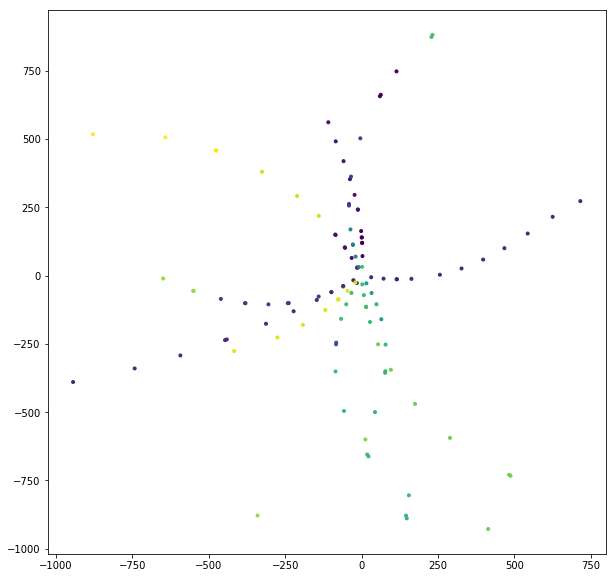

In [72]:
figure = plt.figure(figsize=(10,10))
plt.scatter(df_test.x, df_test.y, marker='.',c=df_test['labels'])
plt.show()

In [74]:
#leaf size 100
path_to_train = "../data/train"
dataset_submissions = []
dataset_scores = []

mylabels = {}
for event_id, hits, cells, particles, truth in load_dataset(path_to_train, skip=10, nevents=10):
    # Track pattern recognition
    model = Clusterer1()
    labels = model.predict(hits)
    hits['labels'] = labels
    mylabels[event_id] = labels
#     for i, label in enumerate(labels):
#         my_hits = hits[hits.labels == label]
#     # Prepare submission for an event
#     one_submission = create_one_event_submission(event_id, hits, labels)
#     dataset_submissions.append(one_submission)

#     # Score for the event
#     score = score_event(truth, one_submission)
#     dataset_scores.append(score)

#     print("Score for event %d: %.9f" % (event_id, score))
# print('Mean score: %.9f' % (np.mean(dataset_scores)))

100%|██████████| 9458/9458 [00:00<00:00, 215220.88it/s]


In [77]:
mylabels

{1010: array([1211, 1479, 1424, ..., 6736, 1017, 8638]),
 1011: array([1100,  966, 1241, ..., 1480,  142,  144]),
 1012: array([ 947, 4154, 1036, ..., 2169, 2184, 9724]),
 1013: array([1321, 1345, 1192, ...,  519, 7048,  498]),
 1014: array([10971,  2696,  2282, ...,   703,  1135,  1135]),
 1015: array([3719, 3702, 4435, ..., 2209, 2209,  462]),
 1016: array([3208, 3060, 3302, ...,  477,  117,  477]),
 1017: array([2704, 3112, 2507, ..., 3761, 1175,  341]),
 1018: array([1348, 1349, 1371, ..., 6120,   81, 6099]),
 1019: array([ 1636,  2186,  2087, ...,  8717, 10838, 10838])}

In [78]:
print(len(labels))

122849


In [79]:
for k, v in mylabels.items():
    print(len(v))

104084
117559
110542
106584
126166
122359
117847
124251
92521
122849


In [81]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,x2,y2,z2,labels
0,1,-88.694702,-9.964630,-1502.5,7,2,1,-0.058928,-0.006620,-16.834225,1636
1,2,-65.322098,-10.131300,-1502.5,7,2,1,-0.043434,-0.006736,-22.729647,2186
2,3,-63.292198,-0.793297,-1502.5,7,2,1,-0.042087,-0.000528,-23.737238,2087
3,4,-91.548897,-6.678430,-1502.5,7,2,1,-0.060818,-0.004437,-16.368500,1702
4,5,-74.582100,-12.916500,-1502.5,7,2,1,-0.049576,-0.008586,-19.850101,2098


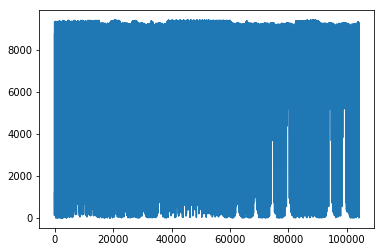

In [84]:
plt.plot(mylabels[1010])
plt.show()

In [85]:
np.min(mylabels[1010])

1

In [86]:
np.max(mylabels[1010])

9422

In [87]:
set(list(range(1,9423))) - set(mylabels[1010])

{8192,
 8193,
 2,
 3,
 8195,
 8196,
 8197,
 8199,
 8200,
 9,
 8204,
 8205,
 8208,
 8209,
 8211,
 21,
 8214,
 8220,
 8221,
 8227,
 8228,
 8229,
 8234,
 8235,
 8236,
 8237,
 53,
 8247,
 8248,
 57,
 8251,
 8252,
 63,
 64,
 8256,
 8261,
 70,
 8263,
 8264,
 8265,
 8270,
 8271,
 8272,
 8274,
 8275,
 86,
 8282,
 8283,
 8285,
 8286,
 8287,
 96,
 8290,
 8291,
 8292,
 8293,
 8294,
 8295,
 8296,
 8297,
 8301,
 8302,
 8303,
 8306,
 8307,
 116,
 8310,
 119,
 8311,
 121,
 8315,
 8317,
 126,
 8319,
 8320,
 8322,
 8323,
 8324,
 8326,
 8327,
 8328,
 8329,
 8331,
 8332,
 8333,
 8334,
 8339,
 148,
 8340,
 8341,
 8343,
 8346,
 8347,
 8349,
 8350,
 8351,
 8353,
 8355,
 8357,
 8359,
 168,
 8360,
 8361,
 8363,
 8364,
 8365,
 8366,
 8367,
 8368,
 8369,
 178,
 8370,
 8371,
 8372,
 8373,
 8374,
 8376,
 8377,
 8378,
 8379,
 8380,
 8381,
 8387,
 197,
 198,
 8392,
 8393,
 8395,
 8397,
 8398,
 8400,
 8402,
 8405,
 215,
 8407,
 8408,
 8409,
 8411,
 222,
 8414,
 8415,
 8419,
 8420,
 8421,
 8422,
 8423,
 8426,
 8427,


In [88]:
len(set(mylabels[1010]))

8054

In [89]:
# path_to_train = "../data/train"
dataset_submissions = []
dataset_scores = []

mylabels1 = {}
for event_id, hits, cells, particles, truth in load_dataset(path_to_train, skip=10, nevents=1):
    
    truth = pd.merge(truth, particles, how='left', on='particle_id')
    hits = pd.merge(hits, truth, how='left', on='hit_id')

    hits = hits.dropna()
    truth = truth.dropna()

    # Track pattern recognition
    model = Clusterer1()
    labels = model.predict(hits)
    hits['labels'] = labels
    mylabels1[event_id] = labels
    
#     # Prepare submission for an event
#     one_submission = create_one_event_submission(event_id, hits, labels)
#     dataset_submissions.append(one_submission)

#     # Score for the event
#     score = score_event(truth, one_submission)
#     dataset_scores.append(score)

#     print("Score for event %d: %.9f" % (event_id, score))
# print('Mean score: %.9f' % (np.mean(dataset_scores)))

100%|██████████| 6658/6658 [00:00<00:00, 199526.12it/s]


In [91]:
hits.sort_values('particle_id', inplace=True)

In [93]:
hits.head(20)

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,vz,px,py,pz,q,nhits,x2,y2,z2,labels
30087,30088,-35.507198,110.550003,-25.930401,8,6,354,4503805785800704,-35.508400,110.549004,...,8.77349,-7.712350,24.13620,-7.572210,-1.0,12.0,-0.298449,0.929207,-0.223322,5475
74205,74206,-154.401001,473.446991,-139.600006,13,6,765,4503805785800704,-154.421005,473.442993,...,8.77349,-7.712350,24.13620,-7.572210,-1.0,12.0,-0.298541,0.915431,-0.280328,5475
23959,23960,-22.017599,68.654198,-12.776200,8,4,218,4503805785800704,-22.015900,68.654999,...,8.77349,-7.712350,24.13620,-7.572210,-1.0,12.0,-0.300698,0.937622,-0.177205,6798
93823,93824,-256.990997,777.700012,-233.000000,17,2,1057,4503805785800704,-256.990997,777.700012,...,8.77349,-7.712350,24.13620,-7.572210,-1.0,12.0,-0.301789,0.913267,-0.284472,5475
68341,68342,-111.233002,342.915985,-98.800003,13,4,549,4503805785800704,-111.222000,342.916992,...,8.77349,-7.712350,24.13620,-7.572210,-1.0,12.0,-0.297574,0.917381,-0.274060,5475
18571,18572,-9.592730,29.951700,-0.621255,8,2,125,4503805785800704,-9.593780,29.951300,...,8.77349,-7.712350,24.13620,-7.572210,-1.0,12.0,-0.304952,0.952163,-0.019754,5480
16687,16688,-9.743420,30.423500,-0.777225,8,2,109,4503805785800704,-9.744890,30.423000,...,8.77349,-7.712350,24.13620,-7.572210,-1.0,12.0,-0.304910,0.952071,-0.024330,5480
79334,79335,-206.667999,629.393982,-188.600006,13,8,898,4503805785800704,-206.664993,629.395020,...,8.77349,-7.712350,24.13620,-7.572210,-1.0,12.0,-0.300049,0.913780,-0.284698,5475
35716,35717,-52.860500,164.225006,-42.787102,8,8,531,4503805785800704,-52.860802,164.225006,...,8.77349,-7.712350,24.13620,-7.572210,-1.0,12.0,-0.297388,0.923914,-0.248009,5475
62277,62278,-78.742798,243.819000,-67.599998,13,2,393,4503805785800704,-78.746002,243.817993,...,8.77349,-7.712350,24.13620,-7.572210,-1.0,12.0,-0.297158,0.920118,-0.263837,5475


In [6]:
model = load_model('../cache/checkpoint/checkpoint-6488-100-3000.hdf5')

In [10]:
path_to_train = "../data/train"
dataset_submissions = []
dataset_scores = []

mylabels1 = {}
for event_id, hits, cells, particles, truth in load_dataset(path_to_train, skip=10, nevents=1):
    
    truth = pd.merge(truth, particles, how='left', on='particle_id')
    hits = pd.merge(hits, truth, how='left', on='hit_id')

    hits = hits.dropna()
    truth = truth.dropna()

    # Track pattern recognition
    model1 = Clusterer1()
    labs = model1.predict(hits)
    hits['labels'] = labs
    mylabels1[event_id] = labs
    
    all_hits = pd.DataFrame()
    prev_p_len = 0
    for i, label in tqdm(enumerate(list(set(labs)))):
#         print(i)
#         print(label)
        myhits = hits[hits['labels'] == label]
        X_test = myhits[['x2', 'y2', 'z2']].values

        p = model.predict(X_test.reshape(X_test.shape[0],1,3))    
        p = [np.argmax(p[j]) + 1 + (i * prev_p_len) for j in range(len(p))]
        prev_p_len = len(p)
        myhits['labels1'] = p
        all_hits = all_hits.append(myhits)
    all_hits.sort_values('hit_id', inplace=True)
    # Prepare submission for an event
    one_submission = create_one_event_submission(event_id, all_hits, all_hits['labels1'].values)
#     dataset_submissions.append(one_submission)

    # Score for the event
    score = score_event(truth, one_submission)
    dataset_scores.append(score)

    print("Score for event %d: %.9f" % (event_id, score))
print('Mean score: %.9f' % (np.mean(dataset_scores)))

100%|██████████| 6658/6658 [00:00<00:00, 163762.94it/s]
6657it [11:59,  9.26it/s]


Score for event 1010: 0.234796436
Mean score: 0.234796436


In [12]:
score = score_event(all_hits, one_submission)
print(score)

0.23479643620180468


In [19]:
df_train = pd.read_csv('../cache/hits_6488_nid_z_sorted_ge9_train_100.csv')
df_valid = pd.read_csv('../cache/hits_6488_nid_z_sorted_ge9_valid_25.csv')
df_test = pd.read_csv('../cache/hits_6488_nid_z_sorted_ge9_test_10.csv')

In [ ]:
def my_loss_np(y_true, y_pred):
    
    labels = [np.argmax(y_pred[i]) for i in range(y_pred.shape[1])]
#     print(labels)
    one_submission = create_one_event_submission(0, df_valid, labels)

    # Score for the event
    score = score_event(df_valid, one_submission)
    loss = 1.0-score
    return loss

In [78]:
import keras.backend as K
def my_loss(y_true, y_pred):
    loss = K.eval(my_loss_np(K.eval(y_true), K.eval(y_pred)))
    return loss

In [79]:
# my_loss(np.array([0,1,2]), np.array([3,4,5]))

In [96]:
model = Sequential()
# model.add(BatchNormalization(input_shape=(1,2)))
model.add(Bidirectional(LSTM(1024, return_sequences=True), input_shape=(1,3)))
# model.add(Bidirectional(LSTM(100, return_sequences=True)))
# model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Bidirectional(LSTM(1024)))
# model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))

# model.add(Dense(100000, activation='relu'))

# model.add(Dropout(0.1))
model.add(Dense(100, activation='softmax'))
kwargs = {}
kwargs['weights'] = None
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

In [97]:
str1='../cache/checkpoint/checkpoint-6488-100-1'
str2 = '{epoch:02d}.hdf5'
filepath = str1 + '-' + str2
checkpoint = ModelCheckpoint(filepath, verbose=0, save_best_only=False)
callbacks_list = [checkpoint]

X_train = df_train[['x', 'y', 'z']].values
X_valid = df_valid[['x', 'y', 'z']].values

y_l = list(range(100))
y_nid = list(set(df_train['nid'].values))
y_map = dict(zip(y_nid, y_l))
y_rev_map = dict(zip(y_l, y_nid))
# print(y)
print(X_train.shape)

y_l_v = list(range(25))
y_nid_v = list(set(df_valid['nid'].values))
y_map_v = dict(zip(y_nid_v, y_l_v))
y_rev_map_v = dict(zip(y_l_v, y_nid_v))


(1187, 3)


In [98]:
y = [y_map[nid] for nid in df_train.nid.values]
y_v = [y_map_v[nid] for nid in df_valid.nid.values]

In [99]:
%%time
model.fit(X_train.reshape(X_train.shape[0], 1, 3), y, batch_size=32, epochs=3000, shuffle=False, verbose=0,
          callbacks=callbacks_list)
#          validation_data=[X_valid.reshape(X_valid.shape[0],1,3), y_v])

CPU times: user 3d 48min 27s, sys: 11h 57min 44s, total: 3d 12h 46min 12s
Wall time: 8h 54min 53s


In [100]:
path_to_train = "../data/train"
dataset_submissions = []
dataset_scores = []

mylabels1 = {}
for event_id, hits, cells, particles, truth in load_dataset(path_to_train, skip=10, nevents=1):
    
    truth = pd.merge(truth, particles, how='left', on='particle_id')
    hits = pd.merge(hits, truth, how='left', on='hit_id')

    hits = hits.dropna()
    truth = truth.dropna()

    # Track pattern recognition
    model1 = Clusterer1()
    labs = model1.predict(hits)
    hits['labels'] = labs
    mylabels1[event_id] = labs
    
    all_hits = pd.DataFrame()
    prev_p_len = 0
    for i, label in tqdm(enumerate(list(set(labs)))):
#         print(i)
#         print(label)
        myhits = hits[hits['labels'] == label]
        X_test = myhits[['x2', 'y2', 'z2']].values

        p = model.predict(X_test.reshape(X_test.shape[0],1,3))    
        p = [np.argmax(p[j]) + 1 + (i * prev_p_len) for j in range(len(p))]
        prev_p_len = len(p)
        myhits['labels1'] = p
        all_hits = all_hits.append(myhits)
    all_hits.sort_values('hit_id', inplace=True)
    # Prepare submission for an event
    one_submission = create_one_event_submission(event_id, all_hits, all_hits['labels1'].values)
#     dataset_submissions.append(one_submission)

    # Score for the event
    score = score_event(truth, one_submission)
    dataset_scores.append(score)

    print("Score for event %d: %.9f" % (event_id, score))
print('Mean score: %.9f' % (np.mean(dataset_scores)))

100%|██████████| 6658/6658 [00:00<00:00, 161585.41it/s]
6657it [52:45,  2.10it/s]


Score for event 1010: 0.239196254
Mean score: 0.239196254


In [101]:
df_train = pd.read_csv('../cache/hits_6488_nid_z_sorted_ge9_train_20.csv')
df_valid = pd.read_csv('../cache/hits_6488_nid_z_sorted_ge9_valid_6.csv')
df_test = pd.read_csv('../cache/hits_6488_nid_z_sorted_ge9_test_5.csv')

In [102]:
model = Sequential()
# model.add(BatchNormalization(input_shape=(1,2)))
model.add(Bidirectional(LSTM(512, return_sequences=True), input_shape=(1,3)))
# model.add(Bidirectional(LSTM(100, return_sequences=True)))
# model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Bidirectional(LSTM(512)))
# model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))

# model.add(Dense(100000, activation='relu'))

# model.add(Dropout(0.1))
model.add(Dense(20, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

In [103]:
str1='../cache/checkpoint/checkpoint-6488-20-1'
str2 = '{epoch:02d}.hdf5'
filepath = str1 + '-' + str2
checkpoint = ModelCheckpoint(filepath, verbose=0, save_best_only=False)
callbacks_list = [checkpoint]

X_train = df_train[['x', 'y', 'z']].values
X_valid = df_valid[['x', 'y', 'z']].values

y_l = list(range(20))
y_nid = list(set(df_train['nid'].values))
y_map = dict(zip(y_nid, y_l))
y_rev_map = dict(zip(y_l, y_nid))
# print(y)
print(X_train.shape)

y_l_v = list(range(6))
y_nid_v = list(set(df_valid['nid'].values))
y_map_v = dict(zip(y_nid_v, y_l_v))
y_rev_map_v = dict(zip(y_l_v, y_nid_v))

y = [y_map[nid] for nid in df_train.nid.values]
y_v = [y_map_v[nid] for nid in df_valid.nid.values]

(243, 3)


In [104]:
%%time
model.fit(X_train.reshape(X_train.shape[0], 1, 3), y, batch_size=32, epochs=3000, shuffle=False, verbose=0,
          callbacks=callbacks_list)
#          validation_data=[X_valid.reshape(X_valid.shape[0],1,3), y_v])

CPU times: user 3h 42min 20s, sys: 6min 58s, total: 3h 49min 18s
Wall time: 36min 41s


In [ ]:
path_to_train = "../data/train"
dataset_submissions = []
dataset_scores = []

mylabels1 = {}
for event_id, hits, cells, particles, truth in load_dataset(path_to_train, skip=10, nevents=1):
    
    truth = pd.merge(truth, particles, how='left', on='particle_id')
    hits = pd.merge(hits, truth, how='left', on='hit_id')

    hits = hits.dropna()
    truth = truth.dropna()

    # Track pattern recognition
    model1 = Clusterer1()
    labs = model1.predict(hits)
    hits['labels'] = labs
    mylabels1[event_id] = labs
    
    all_hits = pd.DataFrame()
    prev_p_len = 0
    for i, label in tqdm(enumerate(list(set(labs)))):
#         print(i)
#         print(label)
        myhits = hits[hits['labels'] == label]
        X_test = myhits[['x2', 'y2', 'z2']].values

        p = model.predict(X_test.reshape(X_test.shape[0],1,3))    
        p = [np.argmax(p[j]) + 1 + (i * prev_p_len) for j in range(len(p))]
        prev_p_len = len(p)
        if prev_p_len < 100:
            prev_p_len = 100
        myhits['labels1'] = p
        all_hits = all_hits.append(myhits)
    all_hits.sort_values('hit_id', inplace=True)
    # Prepare submission for an event
    one_submission = create_one_event_submission(event_id, all_hits, all_hits['labels1'].values)
#     dataset_submissions.append(one_submission)

    # Score for the event
    score = score_event(truth, one_submission)
    dataset_scores.append(score)

    print("Score for event %d: %.9f" % (event_id, score))
print('Mean score: %.9f' % (np.mean(dataset_scores)))

In [145]:
def my_loss_np(y_true, y_pred):
    
    labels = [np.argmax(y_pred[i]) for i in range(len(y_pred))]

    one_submission = create_one_event_submission(0, df_valid, labels)

    # Score for the event
    score = score_event(df_valid, one_submission)
    loss = 1.0-score
    return loss

In [146]:
import keras.backend as K
def my_loss(y_true, y_pred):
    loss = K.eval(my_loss_np(K.eval(y_true), K.eval(y_pred)))
    return loss

In [147]:
model = Sequential()
# model.add(BatchNormalization(input_shape=(1,2)))
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(1,3)))
# model.add(Bidirectional(LSTM(100, return_sequences=True)))
# model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Bidirectional(LSTM(128)))

model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dropout(0.1))
model.add(Dense(20, activation='softmax'))


In [148]:
print(model.summary())

In [149]:
model.compile(loss=my_loss, optimizer='adam')

InvalidArgumentError: You must feed a value for placeholder tensor 'dense_97_target' with dtype float and shape [?,?]
	 [[Node: dense_97_target = Placeholder[dtype=DT_FLOAT, shape=[?,?], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'dense_97_target', defined at:
  File "/home/watts/anaconda3/envs/tmlf/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/watts/anaconda3/envs/tmlf/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2856, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-149-2a16083f7d9e>", line 1, in <module>
    model.compile(loss=my_loss, optimizer='adam')
  File "/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/keras/models.py", line 863, in compile
    **kwargs)
  File "/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/keras/engine/training.py", line 725, in compile
    dtype=K.dtype(self.outputs[i]))
  File "/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 508, in placeholder
    x = tf.placeholder(dtype, shape=shape, name=name)
  File "/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1808, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 4848, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/home/watts/anaconda3/envs/tmlf/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'dense_97_target' with dtype float and shape [?,?]
	 [[Node: dense_97_target = Placeholder[dtype=DT_FLOAT, shape=[?,?], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [108]:
str1='../cache/checkpoint/checkpoint-6488-20-2'
str2 = '{epoch:02d}.hdf5'
filepath = str1 + '-' + str2
checkpoint = ModelCheckpoint(filepath, verbose=0, save_best_only=False)
callbacks_list = [checkpoint]

X_train = df_train[['x', 'y', 'z']].values
X_valid = df_valid[['x', 'y', 'z']].values

y_l = list(range(20))
y_nid = list(set(df_train['nid'].values))
y_map = dict(zip(y_nid, y_l))
y_rev_map = dict(zip(y_l, y_nid))
# print(y)
print(X_train.shape)

y_l_v = list(range(6))
y_nid_v = list(set(df_valid['nid'].values))
y_map_v = dict(zip(y_nid_v, y_l_v))
y_rev_map_v = dict(zip(y_l_v, y_nid_v))

y = [y_map[nid] for nid in df_train.nid.values]
y_v = [y_map_v[nid] for nid in df_valid.nid.values]

(243, 3)


In [111]:
%%time
model.fit(X_train.reshape(X_train.shape[0], 1, 3), y, batch_size=32, epochs=3000, shuffle=False, verbose=1,
#           callbacks=callbacks_list)
         validation_data=[X_valid.reshape(X_valid.shape[0],1,3), y_v])

KeyboardInterrupt: 